## Loading libraries

In [1]:
import pandas as pd
from pandas.api.types import is_string_dtype, is_numeric_dtype
import numpy as np
from gensim import models,corpora
import spacy
from tqdm import tqdm_notebook,tqdm,tqdm_pandas,tnrange
import re
from sklearn.model_selection import train_test_split
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt 
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
import seaborn as sns

In [2]:
PATH = Path('/data/ssubrahmannian/.kaggle/competitions/mercari-price-suggestion-challenge')
list(PATH.iterdir())

[PosixPath('/data/ssubrahmannian/.kaggle/competitions/mercari-price-suggestion-challenge/glove.6B.200d.txt'),
 PosixPath('/data/ssubrahmannian/.kaggle/competitions/mercari-price-suggestion-challenge/glove.6B.zip'),
 PosixPath('/data/ssubrahmannian/.kaggle/competitions/mercari-price-suggestion-challenge/train.tsv'),
 PosixPath('/data/ssubrahmannian/.kaggle/competitions/mercari-price-suggestion-challenge/test.tsv'),
 PosixPath('/data/ssubrahmannian/.kaggle/competitions/mercari-price-suggestion-challenge/glove.6B.100d.txt'),
 PosixPath('/data/ssubrahmannian/.kaggle/competitions/mercari-price-suggestion-challenge/glove.6B.300d.txt'),
 PosixPath('/data/ssubrahmannian/.kaggle/competitions/mercari-price-suggestion-challenge/glove.6B.50d.txt')]

## Functions

In [3]:
def loadGloveModel(gloveFile):
    """ Loads word vectors into a dictionary."""
    f = open(gloveFile,'r')
    word_vecs = {}
    for line in tqdm(f,desc='Loading W2V',bar_format='r_bar'):
        splitLine = line.split()
        word = splitLine[0]
        word_vecs[word] = np.array([float(val) for val in splitLine[1:]])
    return word_vecs

def delete_rare_words(word_vecs, data_vocab, min_df=2):
    """ Deletes rare words from data_vocab
    
    Deletes words from data_vocab if they are not in word_vecs
    and don't have at least min_df occurrencies in data_vocab.
    """
    words_delete = []
    data_vocab = Counter(data_vocab)
    for word in tqdm(data_vocab,desc='rare word normalization'):
        if data_vocab[word] < min_df and word not in word_vecs:
            words_delete.append(word)
    for word in words_delete: data_vocab.pop(word)
    return data_vocab,words_delete

def train_cats(df):
    df = df.copy()
    cat_mapper = {}
    for n,c in df.items(): 
        df[n] = c.astype('category').cat.as_ordered()
        cat_mapper[n] = df[n].cat.categories
    return df, cat_mapper    

def apply_cats(df, cat_mapper):
    df = df.copy()
    for n,c in df.items():
        df[n] = pd.Categorical(c, categories=cat_mapper[n], ordered=True)
    return df

def fix_missing(df, col, name, na_dict):
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict

def numericalize(df, col, name):
    if not is_numeric_dtype(col):
        df[name] = col.cat.codes+1
        
def tokenize_text(df_col):
    text_corpus = df_col.apply(lambda x: x.lower()).values
    removal=['ADV','PRON','CCONJ','PUNCT',
                                   'PART','DET','ADP','SPACE','VERB']
    text_out_final = []

    for review in tqdm(nlp.pipe(text_corpus,n_threads=24,
                                batch_size=10000),desc='Creating tokens'):
        text_out = []
        for token in review:
            if token.pos_ not in removal and token.is_punct == False and token.is_stop == False:
                lemma = token.lemma_
                if lemma != '-PRON-':
                    text_out.append(lemma)

        text_out_final.append(text_out)
    return text_out_final

def get_vocab(text_out):
    finalList =[]
    for sublist in tqdm(text_out,desc='vocab-creation'):
        for item in sublist:
            finalList.append(item)
    return finalList

def create_embedding_matrix(word_vecs,data_vocab, min_df=2, D=300):
    """Creates embedding matrix from word vectors. """
    data_vocab,deleted_words = delete_rare_words(word_vecs, data_vocab, min_df)
    V = len(data_vocab.keys()) + 2
    vocab2index = {}
    W = np.zeros((V, D), dtype="float32")
    vocab = ["", "UNK"]
    # adding a vector for padding
    W[0] = np.zeros(D, dtype='float32')
    # adding a vector for rare words 
    W[1] = np.random.uniform(-0.25,0.25,D)
    vocab2index["UNK"] = 1
    i = 2
    for word in tqdm(data_vocab,desc='EM_creation'):
        if word in word_vecs:
            W[i] = word_vecs[word]
            vocab2index[word] = i
            vocab.append(word)
            i += 1
        else:
            W[i] = np.random.uniform(-0.25,0.25,D)
            vocab2index[word] = i
            vocab.append(word)
            i += 1   
    return W, np.array(vocab), vocab2index,deleted_words

def encode_tokens(token_list,vocab2index, N=40):
    enc = np.zeros(N, dtype=np.int32)
    enc1 = np.array([vocab2index.get(w, vocab2index["UNK"]) for w in token_list])
    l = min(N, len(enc1))
    enc[:l] = enc1[:l]
    return enc

In [38]:
nlp = spacy.load('en')
tqdm_notebook()
tqdm.pandas(tqdm, leave=False)

## Loading Data and transforming price for accounting for skewness

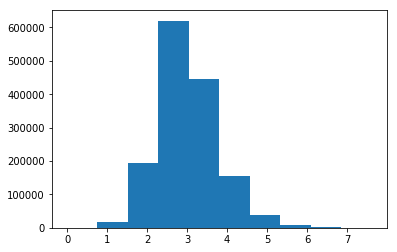

In [5]:
train_df = pd.read_csv(PATH/'train.tsv',sep = '\t')
train_df.price = np.log1p(train_df.price)
plt.hist(train_df.price)
plt.show()

In [6]:
train_df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,2.397895,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,3.970292,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,2.397895,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,3.583519,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,3.806662,0,Complete with certificate of authenticity


In [7]:
train_df.shape, train_df.category_name.nunique(),train_df.name.nunique(), train_df.item_condition_id.nunique(),train_df.brand_name.nunique()

((1482535, 8), 1287, 1225273, 5, 4809)

## Train-test split

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(train_df.drop(['price','train_id'],axis=1), train_df['price'], test_size=0.2, random_state=42)

In [9]:
X_train.head()

,name,item_condition_id,category_name,brand_name,shipping,item_description
1416089,LuLaRoe kids L/XL leggings,3,Kids/Boys (4+)/Bottoms,NaN,1,Worn once. Still in great condition
1423955,Bundle 5 Display mannequins,1,Other/Other/Other,NaN,0,Brand new
403867,LIVING PROOF PERFECT HAIR DAY DRY SHAMPO,1,Beauty/Hair Care/Styling Products,NaN,0,This listing is for 3 full size bottles of liv...
701974,Palazzo pants,2,Women/Pants/Casual Pants,NaN,0,Like new adorable black and white palazzo pant...
1124330,RESERVED FOR Ms Jas PINK BOYSHORTS LARGE,1,Women/Underwear/Panties,PINK,1,NEW WITH TAGS MORNING SKY SHEER SEAFOAM OLIVE ...


In [10]:
X_train.groupby('brand_name').size().sort_values(ascending=False)/sum(X_train.groupby('brand_name').size())*100

brand_name
Nike                    6.381017
PINK                    6.357486
Victoria's Secret       5.660397
LuLaRoe                 3.649867
Apple                   2.030237
FOREVER 21              1.788755
Nintendo                1.753901
Lululemon               1.705369
Michael Kors            1.641837
American Eagle          1.566246
Rae Dunn                1.444770
Sephora                 1.438593
Coach                   1.235202
Disney                  1.229760
Bath & Body Works       1.212406
Adidas                  1.200788
Funko                   1.084901
Under Armour            0.993426
Sony                    0.933571
Old Navy                0.896804
Hollister               0.810771
Carter's                0.758710
Urban Decay             0.727532
The North Face          0.717973
Independent             0.702237
Too Faced               0.675471
Brandy Melville         0.671941
Xbox                    0.667971
Kate Spade              0.634587
MAC                     0.630616

In [11]:
X_valid.groupby('brand_name').size().sort_values(ascending=False)/sum(X_train.groupby('brand_name').size())*100

brand_name
PINK                             1.596982
Nike                             1.566834
Victoria's Secret                1.404033
LuLaRoe                          0.912687
Apple                            0.517229
Nintendo                         0.453108
FOREVER 21                       0.444578
Lululemon                        0.435607
Michael Kors                     0.406489
American Eagle                   0.382958
Rae Dunn                         0.364869
Sephora                          0.351486
Bath & Body Works                0.310308
Coach                            0.303543
Adidas                           0.299572
Disney                           0.293836
Funko                            0.273541
Under Armour                     0.250893
Sony                             0.242070
Old Navy                         0.216039
Hollister                        0.211039
The North Face                   0.189714
Urban Decay                      0.185743
Carter's               

## Baseline Performance

In [12]:
print('Baseline performance using Mean: ',np.std(y_train))
print('Baseline performance using Median: ',np.sqrt(np.mean(np.square(y_train-np.median(y_train)))))

Baseline performance using Mean:  0.7487420031571906
Baseline performance using Median:  0.7539081143640675


## Getting emb sizes for categorical variables and  word2vec models

In [13]:
# number of categories for categories with more than 2 categories
cats = ['item_condition_id', 'category_name', 'brand_name','shipping']
xtrain,_ = train_cats(X_train)
emb_c = {n: len(col.cat.categories) for n,col in xtrain[cats].items()}
for n,c in xtrain.items(): numericalize(xtrain, c, n)
# size of the category, size of the embedding
# 30 and (c+1)//2) are arbitrary (we should play with these numbers)
emb_szs = [(c+1, min(50, max((c+1)//2,2))) for _,c in emb_c.items()]
emb_szs

[(6, 3), (1267, 50), (4557, 50), (3, 2)]

In [14]:
word_vecs = loadGloveModel(PATH/"glove.6B.300d.txt")

Loading W2V: 400000it [00:30, 13074.67it/s]


In [15]:
# x_len = np.array([len(x) for x in text_out_final])
# np.percentile(x_len,95)
# 95th percentile needs is 58. Length of each sentence is taken at 55

## Data Class

In [16]:
class Mercari(Dataset):
    
    def __init__(self, df,y,cats,pretrained_vecs,mapper=None,
                 vocab2index= None,emb_dim = 300,rare_words_def =2,review_len =60):
        self.cats = df[cats]
        self.target= y.values
        self.desc = df['item_description'].fillna('No description')+' '+ df['name'].fillna(' ')+ ' '+df['category_name'].fillna(' ')
        self.mapper = mapper
        self.vocab2index = vocab2index
        self.min_df = rare_words_def
        self.n_review = review_len
        self.emb_dim = emb_dim
        self.pretrained_vecs = pretrained_vecs
        self._label_encoder()
        
    def _label_encoder(self):
        if self.mapper is None:
            self.cats,catMap = train_cats(self.cats)
            self.mapper = catMap
        else:
            self.cats = apply_cats(self.cats,self.mapper)
        for n,c in self.cats.items(): numericalize(self.cats, c, n)
        self.cats = self.cats.values.astype(np.int64)
    
    def process_text(self,load=False,train=False):
        if load is True and train is True:
            print('Loading tokenized text for train')
            with open('text_tokens_train.pkl','rb') as f:
                tokenized_text = pickle.load(f)
        elif load is False and train is True:
            print('Creating tokenized text for train')
            tokenized_text = tokenize_text(self.desc)
            with open('text_tokens_train.pkl','wb') as f:
                pickle.dump(tokenized_text,f)
        elif load is True and train is False:
            print('Loading tokenized text for validation')
            with open('text_tokens_valid.pkl','rb') as f:
                tokenized_text = pickle.load(f) 
        elif load is False and train is False:
            print('Creating tokenized text for validation')
            tokenized_text = tokenize_text(self.desc)
            with open('text_tokens_valid.pkl','wb') as f:
                pickle.dump(tokenized_text,f)        
        
        if train is True:
            data_vocab = get_vocab(tokenized_text)
            final_pretrained_weight, vocab, vocab2index,deleted_words = create_embedding_matrix(self.pretrained_vecs,data_vocab, min_df=self.min_df, D=self.emb_dim)
            self.vocab2index = vocab2index
        self.desc = np.vstack([encode_tokens(x,self.vocab2index,N = self.n_review) for x in tqdm(tokenized_text,desc='Encoding_tokens')])
        self.desc = self.desc.astype(np.int64)
        print('dict length check:',len(self.vocab2index))
        print('encode check:',np.max(self.desc))
        
        if train:
            return final_pretrained_weight,vocab,deleted_words
        else:
            return None
    
    def __len__(self):
        return len(self.target)
    
    def __getitem__(self,idx):
        return [self.cats[idx],self.desc[idx],self.target[idx]]
              

In [17]:
train_ds = Mercari(X_train,y_train,cats,word_vecs,review_len=55)
pretrained_weight,vocab,deleted_words = train_ds.process_text(load=True,train=True)

Loading tokenized text for train


Encoding_tokens: 100%|██████████| 1186028/1186028 [00:14<00:00, 83880.29it/s]


dict length check: 108857
encode check: 108857


In [18]:
val_ds = Mercari(X_valid,y_valid,cats,word_vecs,train_ds.mapper,vocab2index=train_ds.vocab2index,review_len =55)
val_ds.process_text(load=True,train=False)

Loading tokenized text for validation


Encoding_tokens: 100%|██████████| 296507/296507 [00:03<00:00, 84217.83it/s]


dict length check: 108857
encode check: 108857


In [19]:
batch_size  = 5000
train_dl = DataLoader(train_ds, batch_size=batch_size,shuffle=True)
vld_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

In [20]:
V = len(pretrained_weight)
D = 300
N = 40

## Architecture

In [21]:
class CNN(nn.Module):
    
    def __init__(self, V, D, pretrained_weights,emb_szs,sent_len,
                 conv_out_ch=175,hidd_lin_layer=[350,150],kernels =[2,3,4,5],dp = [0.5,0,0,0]):
        
        super(CNN, self).__init__()
        
        self.glove_weights = pretrained_weights
        self.cat_embs = nn.ModuleList([nn.Embedding(c, s) for c,s in emb_szs]) 
        self.n_emb= sum(e.embedding_dim for e in self.cat_embs) 
        
        # Initializing embeddings
        self.textembed = nn.Embedding(V, D, padding_idx=0)
        self.textembed.weight.data.copy_(torch.from_numpy(self.glove_weights))
        self.textembed.weight.requires_grad = False ## freeze embeddings
        
        # Covolution layers
        self.conv_2 = nn.Conv1d(in_channels=D, out_channels=conv_out_ch, kernel_size=kernels[0])
        self.conv_3 = nn.Conv1d(in_channels=D, out_channels=conv_out_ch, kernel_size=kernels[1])
        self.conv_4 = nn.Conv1d(in_channels=D, out_channels=conv_out_ch, kernel_size=kernels[2])
        self.conv_5 = nn.Conv1d(in_channels=D, out_channels=conv_out_ch, kernel_size=kernels[3])
        
        # fully connected layers
        self.lin1 = nn.Linear(self.n_emb + 4*conv_out_ch, hidd_lin_layer[0])
        self.lin2 = nn.Linear(hidd_lin_layer[0], hidd_lin_layer[1])
        self.lin3 = nn.Linear(hidd_lin_layer[1], 1)
        
        # dropouts
        self.post_conv_dp = nn.Dropout(p=dp[0])
        self.cat_emb_dp = nn.Dropout(dp[1])#0.5
        self.ln1_dp = nn.Dropout(dp[2])    #0.2
        self.ln2_dp = nn.Dropout(dp[3])
        
        # batch normalization
        self.ln1_bn = nn.BatchNorm1d(hidd_lin_layer[0])
        self.ln2_bn = nn.BatchNorm1d(hidd_lin_layer[1])
        self.cat_text_bn = nn.BatchNorm1d(self.n_emb + 4*conv_out_ch)
        self.cat_bn = nn.BatchNorm1d(self.n_emb)
        self.post_conv_bn = nn.BatchNorm1d(4*conv_out_ch)
        
        # Maxpooling layers
        self.mp1 = nn.MaxPool1d(kernel_size=sent_len-kernels[0]+1)
        self.mp2 = nn.MaxPool1d(kernel_size=sent_len-kernels[1]+1)
        self.mp3 = nn.MaxPool1d(kernel_size=sent_len-kernels[2]+1)
        self.mp4 = nn.MaxPool1d(kernel_size=sent_len-kernels[3]+1)
               
        
    def forward(self, x_cat,x_text):
  
        x1 = self.textembed(x_text)
        x1 = x1.transpose(1,2)
        
        x2 = F.relu(self.conv_2(x1))
        x3 = F.relu(self.conv_3(x1))
        x4 = F.relu(self.conv_4(x1))
        x5 = F.relu(self.conv_5(x1))
        x2 = self.mp1(x2)
        x3 = self.mp2(x3)
        x4 = self.mp3(x4)
        x5 = self.mp4(x5)
        out = torch.cat([x2,x3, x4, x5], 2)
        out = out.view(out.size(0), -1)
        out = self.post_conv_bn(out)
        out = self.post_conv_dp(out)
        
        # concatenating categorical + convolution layers
        x_c = [e(x_cat[:,i]) for i,e in enumerate(self.cat_embs)]
        x_c = torch.cat(x_c, 1)
        x_c = self.cat_bn(x_c)
        x_c = self.cat_emb_dp(x_c)
        x = torch.cat([x_c, out], 1)
        
        # Linear layers
        x = self.cat_text_bn(x)
        
        # Layer1
        x = F.relu(self.lin1(x))
        x = self.ln1_bn(x)
        x = self.ln1_dp(x)        
        
        # Layer2        
        x = F.relu(self.lin2(x))
        x = self.ln2_bn(x)
        x = self.ln2_dp(x)
        
        # Layer2 aka output        
        x = self.lin3(x)
        return x

## Training loop 

In [22]:
def train_model(model, optim, train_dl=train_dl, verbose=False, unsqueeze =False,gpu=False):

    # Setting model in train mode
    model.train()
    total = 0
    sum_loss = 0
    for x_cat,x_text,price in tqdm(train_dl,desc='Training',dynamic_ncols=True):

        batch = price.shape[0]
        price = price.unsqueeze(1)
        price = price.float()
        if gpu:
            x_cat = x_cat.cuda()
            x_text = x_text.cuda()
            price = price.cuda()
        y_hat = model(x_cat,x_text)
        if unsqueeze: y_hat = y_hat.unsqueeze(1)
        loss = F.mse_loss(y_hat,price)
        optim.zero_grad()
        loss.backward()
        optim.step()
        total += batch
        sum_loss += batch*(loss.item())
        if verbose: print(np.sqrt(sum_loss/total))
    return sum_loss/total

def val_loss(model, valid_dl,unsqueeze=False,gpu= False):
    model.eval()
    total = 0
    sum_loss = 0
    for x_cat,x_text,price in tqdm(valid_dl,desc='Validation',dynamic_ncols=True):
        batch = price.shape[0]
        price = price.unsqueeze(1)
        price = price.float()
        if gpu:
            x_cat = x_cat.cuda()
            x_text = x_text.cuda()
            price = price.cuda()

        y_hat = model(x_cat,x_text)
        if unsqueeze: y_hat = y_hat.unsqueeze(1)
        loss = F.mse_loss(y_hat,price)
        sum_loss += batch*(loss.item())
        total += batch
    return sum_loss/total

OUTPUT_PATH = '/data/ssubrahmannian/DL/hw2/models/'
def train_loop(model, epochs, optim, lr=0.01, wd=0.0,gpu=False):
    for i in tnrange(epochs,desc='Epochs:',dynamic_ncols=True): 
        train_loss = train_model(model, optim, train_dl,gpu=gpu)
        vld_loss = val_loss(model, valid_dl=vld_dl,gpu=gpu)
        tqdm.write("Training RMSLE : %f 'Validation RMSLE: %f"%(np.sqrt(train_loss),np.sqrt(vld_loss)),nolock=True)
        if i%10 ==0: 
            model_output_path = f'{OUTPUT_PATH}model_{i}.pth'
            save_model(model,model_output_path)

def get_optimizer(model,lr,wd=0):
    # Setting optimizer
    parameters = filter(lambda x:x.requires_grad,model.parameters())
    optim = torch.optim.Adam(parameters, lr=lr,weight_decay=wd)
    return optim

## Learning rate finder

In [23]:
'''
1. Save the current model and bring it to train mode
2. Decide the number of iterations
3. for each iteration change the lr and train the model
4. Append the loss
5. load a model
'''
model_LR = CNN(V,D,pretrained_weight,emb_szs,sent_len=55).cuda()
parameters = filter(lambda x:x.requires_grad,model_LR.parameters())


def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))
    
def LR_find(model,train_dl,output_path,lr_low = 1e-05,lr_high = 1,epochs=5):
    model.train()
    save_model(model,output_path)
    no_of_batches = len(train_dl)
    bz = train_dl.batch_size
    losses  = []
    lr_list = np.arange(0,epochs*no_of_batches)/(epochs*no_of_batches)*(lr_high-lr_low)+lr_low
    ind = 0
    for i in tqdm_notebook(range(epochs),desc='Epochs'):
        for x1,x2,target in tqdm_notebook(train_dl,desc='batchno',leave=False):
            x1 = x1.cuda()
            x2 = x2.cuda()
            target = target.float()
            target = target.cuda()
            optim = get_optimizer(model,lr_list[ind],0)
            optim.zero_grad()
            y_hat = model(x1,x2)
            target = target.unsqueeze(1)
            loss= F.mse_loss(y_hat,target)
            loss.backward()
            optim.step()
            losses.append(loss.item())
            ind +=1
    load_model(model, output_path)
    
    return lr_list,losses


In [25]:
OUTPUT_PATH = '/data/ssubrahmannian/DL/hw2/models/'

In [25]:
model_output_path = OUTPUT_PATH + "model_1.pth"
# the idea is that you need enough batches to try out all possible values of LR that you want to
lrs, losses = LR_find(model_LR, train_dl,model_output_path, lr_low=1e-5, lr_high=1,epochs=5)

/data/ssubrahmannian/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/data/ssubrahmannian/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


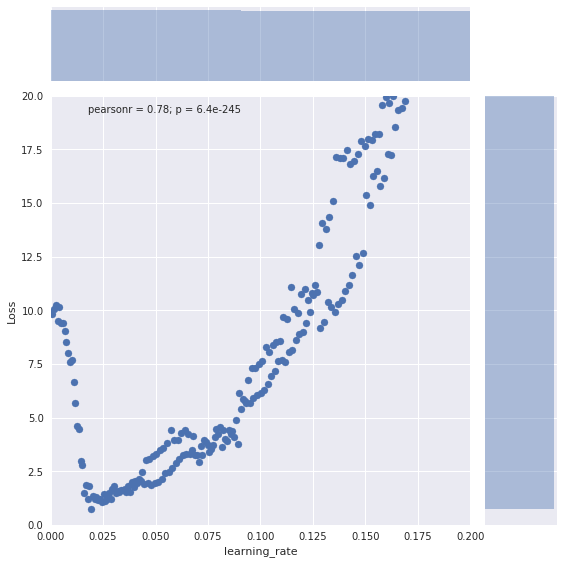

In [26]:
df_plot = pd.DataFrame({'learning_rate':lrs,'Loss':losses})
sns.set(style="darkgrid", color_codes=True)
g = sns.jointplot('learning_rate', 'Loss', data=df_plot, size=8,ylim=(0,20),xlim=(0,0.2))
plt.show() 

In [41]:
df_plot.sort_values(by='Loss').head(1)

,learning_rate,Loss
23,0.019338,0.748662


## Model Execution

In [40]:
model = CNN(V,D,pretrained_weight,emb_szs,sent_len=55,dp=[0.5,0.5,0.5,0.3]).cuda()
parameters = filter(lambda x:x.requires_grad,model.parameters())
# Setting optimizer 
optim = torch.optim.Adam(parameters, lr=0.018,weight_decay=0.0)

In [41]:
train_loop(model,20,optim,gpu=True)




Training:   0%|          | 0/238 [00:00<?, ?it/s]


Training:   0%|          | 1/238 [00:00<02:58,  1.32it/s]


Training:   1%|          | 2/238 [00:01<02:55,  1.34it/s]


Training:   1%|▏         | 3/238 [00:02<02:47,  1.40it/s]


Training:   2%|▏         | 4/238 [00:02<02:42,  1.44it/s]


Training:   2%|▏         | 5/238 [00:03<02:39,  1.46it/s]


Training:   3%|▎         | 6/238 [00:04<02:37,  1.47it/s]


Training:   3%|▎         | 7/238 [00:04<02:38,  1.46it/s]


Training:   3%|▎         | 8/238 [00:05<02:36,  1.47it/s]


Training:   4%|▍         | 9/238 [00:06<02:35,  1.48it/s]


Training:   4%|▍         | 10/238 [00:06<02:33,  1.48it/s]


Training:   5%|▍         | 11/238 [00:07<02:32,  1.49it/s]


Training:   5%|▌         | 12/238 [00:08<02:32,  1.48it/s]


Training:   5%|▌         | 13/238 [00:08<02:31,  1.49it/s]


Training:   6%|▌         | 14/238 [00:09<02:30,  1.49it/s]


Training:   6%|▋         | 15/238 [00:10<02:29,  1.49it/s]


Training:   7%|▋         | 16/238 [00:1

Training:  49%|████▉     | 117/238 [01:17<01:20,  1.51it/s]


Training:  50%|████▉     | 118/238 [01:18<01:19,  1.51it/s]


Training:  50%|█████     | 119/238 [01:18<01:18,  1.51it/s]


Training:  50%|█████     | 120/238 [01:19<01:18,  1.51it/s]


Training:  51%|█████     | 121/238 [01:20<01:17,  1.51it/s]


Training:  51%|█████▏    | 122/238 [01:20<01:16,  1.51it/s]


Training:  52%|█████▏    | 123/238 [01:21<01:16,  1.51it/s]


Training:  52%|█████▏    | 124/238 [01:22<01:15,  1.51it/s]


Training:  53%|█████▎    | 125/238 [01:22<01:14,  1.51it/s]


Training:  53%|█████▎    | 126/238 [01:23<01:14,  1.51it/s]


Training:  53%|█████▎    | 127/238 [01:24<01:13,  1.51it/s]


Training:  54%|█████▍    | 128/238 [01:24<01:12,  1.51it/s]


Training:  54%|█████▍    | 129/238 [01:25<01:12,  1.51it/s]


Training:  55%|█████▍    | 130/238 [01:26<01:11,  1.51it/s]


Training:  55%|█████▌    | 131/238 [01:26<01:10,  1.51it/s]


Training:  55%|█████▌    | 132/238 [01:27<01:10,  1.51it/s]


Training

Training:  97%|█████████▋| 232/238 [02:34<00:03,  1.50it/s]


Training:  98%|█████████▊| 233/238 [02:34<00:03,  1.50it/s]


Training:  98%|█████████▊| 234/238 [02:35<00:02,  1.50it/s]


Training:  99%|█████████▊| 235/238 [02:36<00:01,  1.50it/s]


Training:  99%|█████████▉| 236/238 [02:36<00:01,  1.50it/s]


Training: 100%|█████████▉| 237/238 [02:37<00:00,  1.50it/s]


Training: 100%|██████████| 238/238 [02:37<00:00,  1.51it/s]





Validation:   0%|          | 0/60 [00:00<?, ?it/s]


Validation:   2%|▏         | 1/60 [00:00<00:21,  2.77it/s]


Validation:   3%|▎         | 2/60 [00:00<00:20,  2.77it/s]


Validation:   5%|▌         | 3/60 [00:01<00:21,  2.59it/s]


Validation:   7%|▋         | 4/60 [00:01<00:21,  2.64it/s]


Validation:   8%|▊         | 5/60 [00:01<00:20,  2.66it/s]


Validation:  10%|█         | 6/60 [00:02<00:20,  2.68it/s]


Validation:  12%|█▏        | 7/60 [00:02<00:20,  2.62it/s]


Validation:  13%|█▎        | 8/60 [00:03<00:19,  2.64it/s]


Validation:  15%|█▌   

Training RMSLE : 0.839551 'Validation RMSLE: 0.518106





Training:   0%|          | 0/238 [00:00<?, ?it/s]


Training:   0%|          | 1/238 [00:00<02:52,  1.37it/s]


Training:   1%|          | 2/238 [00:01<02:42,  1.45it/s]


Training:   1%|▏         | 3/238 [00:02<02:38,  1.48it/s]


Training:   2%|▏         | 4/238 [00:02<02:36,  1.50it/s]


Training:   2%|▏         | 5/238 [00:03<02:38,  1.47it/s]


Training:   3%|▎         | 6/238 [00:04<02:36,  1.48it/s]


Training:   3%|▎         | 7/238 [00:04<02:35,  1.49it/s]


Training:   3%|▎         | 8/238 [00:05<02:33,  1.50it/s]


Training:   4%|▍         | 9/238 [00:05<02:32,  1.50it/s]


Training:   4%|▍         | 10/238 [00:06<02:33,  1.49it/s]


Training:   5%|▍         | 11/238 [00:07<02:32,  1.49it/s]


Training:   5%|▌         | 12/238 [00:08<02:31,  1.50it/s]


Training:   5%|▌         | 13/238 [00:08<02:30,  1.50it/s]


Training:   6%|▌         | 14/238 [00:09<02:29,  1.50it/s]


Training:   6%|▋         | 15/238 [00:10<02:29,  1.49it/s]


Training:   7%|▋         | 16/238 [00:1

Training:  49%|████▉     | 117/238 [01:17<01:20,  1.50it/s]


Training:  50%|████▉     | 118/238 [01:18<01:19,  1.50it/s]


Training:  50%|█████     | 119/238 [01:19<01:19,  1.50it/s]


Training:  50%|█████     | 120/238 [01:19<01:18,  1.50it/s]


Training:  51%|█████     | 121/238 [01:20<01:17,  1.50it/s]


Training:  51%|█████▏    | 122/238 [01:21<01:17,  1.50it/s]


Training:  52%|█████▏    | 123/238 [01:21<01:16,  1.50it/s]


Training:  52%|█████▏    | 124/238 [01:22<01:15,  1.50it/s]


Training:  53%|█████▎    | 125/238 [01:23<01:15,  1.50it/s]


Training:  53%|█████▎    | 126/238 [01:23<01:14,  1.50it/s]


Training:  53%|█████▎    | 127/238 [01:24<01:13,  1.50it/s]


Training:  54%|█████▍    | 128/238 [01:25<01:13,  1.50it/s]


Training:  54%|█████▍    | 129/238 [01:25<01:12,  1.50it/s]


Training:  55%|█████▍    | 130/238 [01:26<01:11,  1.50it/s]


Training:  55%|█████▌    | 131/238 [01:27<01:11,  1.50it/s]


Training:  55%|█████▌    | 132/238 [01:27<01:10,  1.50it/s]


Training

Training:  97%|█████████▋| 232/238 [02:34<00:03,  1.50it/s]


Training:  98%|█████████▊| 233/238 [02:35<00:03,  1.50it/s]


Training:  98%|█████████▊| 234/238 [02:35<00:02,  1.50it/s]


Training:  99%|█████████▊| 235/238 [02:36<00:01,  1.50it/s]


Training:  99%|█████████▉| 236/238 [02:37<00:01,  1.50it/s]


Training: 100%|█████████▉| 237/238 [02:37<00:00,  1.50it/s]


Training: 100%|██████████| 238/238 [02:37<00:00,  1.51it/s]





Validation:   0%|          | 0/60 [00:00<?, ?it/s]


Validation:   2%|▏         | 1/60 [00:00<00:25,  2.30it/s]


Validation:   3%|▎         | 2/60 [00:00<00:23,  2.51it/s]


Validation:   5%|▌         | 3/60 [00:01<00:21,  2.59it/s]


Validation:   7%|▋         | 4/60 [00:01<00:21,  2.63it/s]


Validation:   8%|▊         | 5/60 [00:01<00:21,  2.56it/s]


Validation:  10%|█         | 6/60 [00:02<00:20,  2.59it/s]


Validation:  12%|█▏        | 7/60 [00:02<00:20,  2.62it/s]


Validation:  13%|█▎        | 8/60 [00:03<00:19,  2.64it/s]


Validation:  15%|█▌   

Training RMSLE : 0.547197 'Validation RMSLE: 0.493950





Training:   0%|          | 1/238 [00:00<02:46,  1.42it/s]


Training:   1%|          | 2/238 [00:01<02:39,  1.48it/s]


Training:   1%|▏         | 3/238 [00:02<02:43,  1.44it/s]


Training:   2%|▏         | 4/238 [00:02<02:39,  1.46it/s]


Training:   2%|▏         | 5/238 [00:03<02:37,  1.48it/s]


Training:   3%|▎         | 6/238 [00:04<02:35,  1.49it/s]


Training:   3%|▎         | 7/238 [00:04<02:34,  1.50it/s]


Training:   3%|▎         | 8/238 [00:05<02:35,  1.48it/s]


Training:   4%|▍         | 9/238 [00:06<02:34,  1.49it/s]


Training:   4%|▍         | 10/238 [00:06<02:32,  1.49it/s]


Training:   5%|▍         | 11/238 [00:07<02:31,  1.50it/s]


Training:   5%|▌         | 12/238 [00:08<02:30,  1.50it/s]


Training:   5%|▌         | 13/238 [00:08<02:30,  1.49it/s]


Training:   6%|▌         | 14/238 [00:09<02:29,  1.49it/s]


Training:   6%|▋         | 15/238 [00:10<02:28,  1.50it/s]


Training:   7%|▋         | 16/238 [00:10<02:27,  1.50it/s]


Training:   7%|▋         | 17/

Training:  49%|████▉     | 117/238 [01:17<01:20,  1.50it/s]


Training:  50%|████▉     | 118/238 [01:18<01:19,  1.50it/s]


Training:  50%|█████     | 119/238 [01:19<01:19,  1.50it/s]


Training:  50%|█████     | 120/238 [01:19<01:18,  1.50it/s]


Training:  51%|█████     | 121/238 [01:20<01:17,  1.50it/s]


Training:  51%|█████▏    | 122/238 [01:21<01:17,  1.50it/s]


Training:  52%|█████▏    | 123/238 [01:21<01:16,  1.50it/s]


Training:  52%|█████▏    | 124/238 [01:22<01:15,  1.50it/s]


Training:  53%|█████▎    | 125/238 [01:23<01:15,  1.50it/s]


Training:  53%|█████▎    | 126/238 [01:23<01:14,  1.50it/s]


Training:  53%|█████▎    | 127/238 [01:24<01:13,  1.50it/s]


Training:  54%|█████▍    | 128/238 [01:25<01:13,  1.50it/s]


Training:  54%|█████▍    | 129/238 [01:25<01:12,  1.50it/s]


Training:  55%|█████▍    | 130/238 [01:26<01:11,  1.50it/s]


Training:  55%|█████▌    | 131/238 [01:27<01:11,  1.50it/s]


Training:  55%|█████▌    | 132/238 [01:27<01:10,  1.50it/s]


Training

Training:  97%|█████████▋| 232/238 [02:34<00:03,  1.50it/s]


Training:  98%|█████████▊| 233/238 [02:35<00:03,  1.50it/s]


Training:  98%|█████████▊| 234/238 [02:35<00:02,  1.50it/s]


Training:  99%|█████████▊| 235/238 [02:36<00:01,  1.50it/s]


Training:  99%|█████████▉| 236/238 [02:37<00:01,  1.50it/s]


Training: 100%|█████████▉| 237/238 [02:37<00:00,  1.50it/s]


Training: 100%|██████████| 238/238 [02:37<00:00,  1.51it/s]





Validation:   0%|          | 0/60 [00:00<?, ?it/s]


Validation:   2%|▏         | 1/60 [00:00<00:21,  2.80it/s]


Validation:   3%|▎         | 2/60 [00:00<00:20,  2.79it/s]


Validation:   5%|▌         | 3/60 [00:01<00:21,  2.62it/s]


Validation:   7%|▋         | 4/60 [00:01<00:21,  2.65it/s]


Validation:   8%|▊         | 5/60 [00:01<00:20,  2.67it/s]


Validation:  10%|█         | 6/60 [00:02<00:20,  2.69it/s]


Validation:  12%|█▏        | 7/60 [00:02<00:19,  2.70it/s]


Validation:  13%|█▎        | 8/60 [00:03<00:19,  2.65it/s]


Validation:  15%|█▌   

Training RMSLE : 0.526648 'Validation RMSLE: 0.483934





Training:   0%|          | 1/238 [00:00<03:03,  1.29it/s]


Training:   1%|          | 2/238 [00:01<02:47,  1.41it/s]


Training:   1%|▏         | 3/238 [00:02<02:41,  1.45it/s]


Training:   2%|▏         | 4/238 [00:02<02:38,  1.47it/s]


Training:   2%|▏         | 5/238 [00:03<02:36,  1.49it/s]


Training:   3%|▎         | 6/238 [00:04<02:37,  1.47it/s]


Training:   3%|▎         | 7/238 [00:04<02:36,  1.48it/s]


Training:   3%|▎         | 8/238 [00:05<02:34,  1.49it/s]


Training:   4%|▍         | 9/238 [00:06<02:33,  1.49it/s]


Training:   4%|▍         | 10/238 [00:06<02:32,  1.50it/s]


Training:   5%|▍         | 11/238 [00:07<02:32,  1.49it/s]


Training:   5%|▌         | 12/238 [00:08<02:31,  1.49it/s]


Training:   5%|▌         | 13/238 [00:08<02:30,  1.50it/s]


Training:   6%|▌         | 14/238 [00:09<02:29,  1.50it/s]


Training:   6%|▋         | 15/238 [00:10<02:29,  1.49it/s]


Training:   7%|▋         | 16/238 [00:10<02:28,  1.49it/s]


Training:   7%|▋         | 17/

Training:  49%|████▉     | 117/238 [01:17<01:20,  1.51it/s]


Training:  50%|████▉     | 118/238 [01:18<01:19,  1.51it/s]


Training:  50%|█████     | 119/238 [01:18<01:18,  1.51it/s]


Training:  50%|█████     | 120/238 [01:19<01:18,  1.51it/s]


Training:  51%|█████     | 121/238 [01:20<01:17,  1.51it/s]


Training:  51%|█████▏    | 122/238 [01:20<01:16,  1.51it/s]


Training:  52%|█████▏    | 123/238 [01:21<01:16,  1.51it/s]


Training:  52%|█████▏    | 124/238 [01:22<01:15,  1.51it/s]


Training:  53%|█████▎    | 125/238 [01:22<01:15,  1.51it/s]


Training:  53%|█████▎    | 126/238 [01:23<01:14,  1.51it/s]


Training:  53%|█████▎    | 127/238 [01:24<01:13,  1.51it/s]


Training:  54%|█████▍    | 128/238 [01:24<01:12,  1.51it/s]


Training:  54%|█████▍    | 129/238 [01:25<01:12,  1.51it/s]


Training:  55%|█████▍    | 130/238 [01:26<01:11,  1.51it/s]


Training:  55%|█████▌    | 131/238 [01:26<01:11,  1.51it/s]


Training:  55%|█████▌    | 132/238 [01:27<01:10,  1.51it/s]


Training

Training:  97%|█████████▋| 232/238 [02:33<00:03,  1.51it/s]


Training:  98%|█████████▊| 233/238 [02:34<00:03,  1.51it/s]


Training:  98%|█████████▊| 234/238 [02:35<00:02,  1.51it/s]


Training:  99%|█████████▊| 235/238 [02:35<00:01,  1.51it/s]


Training:  99%|█████████▉| 236/238 [02:36<00:01,  1.51it/s]


Training: 100%|█████████▉| 237/238 [02:37<00:00,  1.51it/s]


Training: 100%|██████████| 238/238 [02:37<00:00,  1.51it/s]





Validation:   0%|          | 0/60 [00:00<?, ?it/s]


Validation:   2%|▏         | 1/60 [00:00<00:21,  2.77it/s]


Validation:   3%|▎         | 2/60 [00:00<00:23,  2.52it/s]


Validation:   5%|▌         | 3/60 [00:01<00:21,  2.60it/s]


Validation:   7%|▋         | 4/60 [00:01<00:21,  2.64it/s]


Validation:   8%|▊         | 5/60 [00:01<00:20,  2.66it/s]


Validation:  10%|█         | 6/60 [00:02<00:20,  2.61it/s]


Validation:  12%|█▏        | 7/60 [00:02<00:20,  2.63it/s]


Validation:  13%|█▎        | 8/60 [00:03<00:19,  2.65it/s]


Validation:  15%|█▌   

Training RMSLE : 0.513221 'Validation RMSLE: 0.484120





Training:   0%|          | 1/238 [00:00<02:43,  1.45it/s]


Training:   1%|          | 2/238 [00:01<02:37,  1.49it/s]


Training:   1%|▏         | 3/238 [00:01<02:35,  1.51it/s]


Training:   2%|▏         | 4/238 [00:02<02:38,  1.48it/s]


Training:   2%|▏         | 5/238 [00:03<02:36,  1.49it/s]


Training:   3%|▎         | 6/238 [00:04<02:34,  1.50it/s]


Training:   3%|▎         | 7/238 [00:04<02:33,  1.51it/s]


Training:   3%|▎         | 8/238 [00:05<02:32,  1.51it/s]


Training:   4%|▍         | 9/238 [00:06<02:33,  1.49it/s]


Training:   4%|▍         | 10/238 [00:06<02:32,  1.50it/s]


Training:   5%|▍         | 11/238 [00:07<02:30,  1.50it/s]


Training:   5%|▌         | 12/238 [00:07<02:30,  1.51it/s]


Training:   5%|▌         | 13/238 [00:08<02:30,  1.50it/s]


Training:   6%|▌         | 14/238 [00:09<02:29,  1.50it/s]


Training:   6%|▋         | 15/238 [00:09<02:28,  1.50it/s]


Training:   7%|▋         | 16/238 [00:10<02:27,  1.51it/s]


Training:   7%|▋         | 17/

Training:  49%|████▉     | 117/238 [01:17<01:20,  1.50it/s]


Training:  50%|████▉     | 118/238 [01:18<01:19,  1.50it/s]


Training:  50%|█████     | 119/238 [01:19<01:19,  1.50it/s]


Training:  50%|█████     | 120/238 [01:19<01:18,  1.50it/s]


Training:  51%|█████     | 121/238 [01:20<01:17,  1.50it/s]


Training:  51%|█████▏    | 122/238 [01:21<01:17,  1.50it/s]


Training:  52%|█████▏    | 123/238 [01:21<01:16,  1.50it/s]


Training:  52%|█████▏    | 124/238 [01:22<01:15,  1.50it/s]


Training:  53%|█████▎    | 125/238 [01:23<01:15,  1.50it/s]


Training:  53%|█████▎    | 126/238 [01:23<01:14,  1.50it/s]


Training:  53%|█████▎    | 127/238 [01:24<01:13,  1.50it/s]


Training:  54%|█████▍    | 128/238 [01:25<01:13,  1.50it/s]


Training:  54%|█████▍    | 129/238 [01:25<01:12,  1.50it/s]


Training:  55%|█████▍    | 130/238 [01:26<01:11,  1.50it/s]


Training:  55%|█████▌    | 131/238 [01:27<01:11,  1.50it/s]


Training:  55%|█████▌    | 132/238 [01:27<01:10,  1.50it/s]


Training

Training:  97%|█████████▋| 232/238 [02:34<00:03,  1.50it/s]


Training:  98%|█████████▊| 233/238 [02:35<00:03,  1.50it/s]


Training:  98%|█████████▊| 234/238 [02:35<00:02,  1.50it/s]


Training:  99%|█████████▊| 235/238 [02:36<00:01,  1.50it/s]


Training:  99%|█████████▉| 236/238 [02:37<00:01,  1.50it/s]


Training: 100%|█████████▉| 237/238 [02:37<00:00,  1.50it/s]


Training: 100%|██████████| 238/238 [02:37<00:00,  1.51it/s]





Validation:   0%|          | 0/60 [00:00<?, ?it/s]


Validation:   2%|▏         | 1/60 [00:00<00:21,  2.78it/s]


Validation:   3%|▎         | 2/60 [00:00<00:20,  2.78it/s]


Validation:   5%|▌         | 3/60 [00:01<00:20,  2.78it/s]


Validation:   7%|▋         | 4/60 [00:01<00:21,  2.66it/s]


Validation:   8%|▊         | 5/60 [00:01<00:20,  2.68it/s]


Validation:  10%|█         | 6/60 [00:02<00:20,  2.69it/s]


Validation:  12%|█▏        | 7/60 [00:02<00:19,  2.70it/s]


Validation:  13%|█▎        | 8/60 [00:02<00:19,  2.71it/s]


Validation:  15%|█▌   

Training RMSLE : 0.504828 'Validation RMSLE: 0.473998





Training:   0%|          | 1/238 [00:00<02:46,  1.43it/s]


Training:   1%|          | 2/238 [00:01<02:47,  1.41it/s]


Training:   1%|▏         | 3/238 [00:02<02:42,  1.45it/s]


Training:   2%|▏         | 4/238 [00:02<02:38,  1.47it/s]


Training:   2%|▏         | 5/238 [00:03<02:36,  1.49it/s]


Training:   3%|▎         | 6/238 [00:04<02:34,  1.50it/s]


Training:   3%|▎         | 7/238 [00:04<02:36,  1.48it/s]


Training:   3%|▎         | 8/238 [00:05<02:34,  1.49it/s]


Training:   4%|▍         | 9/238 [00:06<02:33,  1.49it/s]


Training:   4%|▍         | 10/238 [00:06<02:32,  1.50it/s]


Training:   5%|▍         | 11/238 [00:07<02:31,  1.50it/s]


Training:   5%|▌         | 12/238 [00:08<02:31,  1.49it/s]


Training:   5%|▌         | 13/238 [00:08<02:30,  1.49it/s]


Training:   6%|▌         | 14/238 [00:09<02:29,  1.50it/s]


Training:   6%|▋         | 15/238 [00:09<02:28,  1.50it/s]


Training:   7%|▋         | 16/238 [00:10<02:28,  1.49it/s]


Training:   7%|▋         | 17/

Training:  49%|████▉     | 117/238 [01:17<01:20,  1.50it/s]


Training:  50%|████▉     | 118/238 [01:18<01:19,  1.50it/s]


Training:  50%|█████     | 119/238 [01:19<01:19,  1.50it/s]


Training:  50%|█████     | 120/238 [01:19<01:18,  1.50it/s]


Training:  51%|█████     | 121/238 [01:20<01:17,  1.50it/s]


Training:  51%|█████▏    | 122/238 [01:21<01:17,  1.50it/s]


Training:  52%|█████▏    | 123/238 [01:21<01:16,  1.50it/s]


Training:  52%|█████▏    | 124/238 [01:22<01:15,  1.50it/s]


Training:  53%|█████▎    | 125/238 [01:23<01:15,  1.50it/s]


Training:  53%|█████▎    | 126/238 [01:23<01:14,  1.50it/s]


Training:  53%|█████▎    | 127/238 [01:24<01:13,  1.50it/s]


Training:  54%|█████▍    | 128/238 [01:25<01:13,  1.50it/s]


Training:  54%|█████▍    | 129/238 [01:25<01:12,  1.50it/s]


Training:  55%|█████▍    | 130/238 [01:26<01:11,  1.50it/s]


Training:  55%|█████▌    | 131/238 [01:27<01:11,  1.50it/s]


Training:  55%|█████▌    | 132/238 [01:27<01:10,  1.50it/s]


Training

Training:  97%|█████████▋| 232/238 [02:34<00:03,  1.50it/s]


Training:  98%|█████████▊| 233/238 [02:34<00:03,  1.50it/s]


Training:  98%|█████████▊| 234/238 [02:35<00:02,  1.50it/s]


Training:  99%|█████████▊| 235/238 [02:36<00:01,  1.50it/s]


Training:  99%|█████████▉| 236/238 [02:36<00:01,  1.50it/s]


Training: 100%|█████████▉| 237/238 [02:37<00:00,  1.50it/s]


Training: 100%|██████████| 238/238 [02:37<00:00,  1.51it/s]





Validation:   0%|          | 0/60 [00:00<?, ?it/s]


Validation:   2%|▏         | 1/60 [00:00<00:21,  2.78it/s]


Validation:   3%|▎         | 2/60 [00:00<00:23,  2.51it/s]


Validation:   5%|▌         | 3/60 [00:01<00:22,  2.59it/s]


Validation:   7%|▋         | 4/60 [00:01<00:21,  2.63it/s]


Validation:   8%|▊         | 5/60 [00:01<00:20,  2.65it/s]


Validation:  10%|█         | 6/60 [00:02<00:20,  2.67it/s]


Validation:  12%|█▏        | 7/60 [00:02<00:20,  2.62it/s]


Validation:  13%|█▎        | 8/60 [00:03<00:19,  2.64it/s]


Validation:  15%|█▌   

Training RMSLE : 0.497411 'Validation RMSLE: 0.469276





Training:   0%|          | 1/238 [00:00<02:45,  1.44it/s]


Training:   1%|          | 2/238 [00:01<02:38,  1.49it/s]


Training:   1%|▏         | 3/238 [00:01<02:36,  1.50it/s]


Training:   2%|▏         | 4/238 [00:02<02:34,  1.51it/s]


Training:   2%|▏         | 5/238 [00:03<02:37,  1.48it/s]


Training:   3%|▎         | 6/238 [00:04<02:35,  1.49it/s]


Training:   3%|▎         | 7/238 [00:04<02:34,  1.50it/s]


Training:   3%|▎         | 8/238 [00:05<02:32,  1.50it/s]


Training:   4%|▍         | 9/238 [00:05<02:31,  1.51it/s]


Training:   4%|▍         | 10/238 [00:06<02:32,  1.49it/s]


Training:   5%|▍         | 11/238 [00:07<02:31,  1.50it/s]


Training:   5%|▌         | 12/238 [00:07<02:30,  1.50it/s]


Training:   5%|▌         | 13/238 [00:08<02:29,  1.50it/s]


Training:   6%|▌         | 14/238 [00:09<02:30,  1.48it/s]


Training:   6%|▋         | 15/238 [00:10<02:30,  1.49it/s]


Training:   7%|▋         | 16/238 [00:10<02:29,  1.49it/s]


Training:   7%|▋         | 17/

Training:  49%|████▉     | 117/238 [01:17<01:20,  1.50it/s]


Training:  50%|████▉     | 118/238 [01:18<01:19,  1.50it/s]


Training:  50%|█████     | 119/238 [01:19<01:19,  1.50it/s]


Training:  50%|█████     | 120/238 [01:19<01:18,  1.50it/s]


Training:  51%|█████     | 121/238 [01:20<01:17,  1.50it/s]


Training:  51%|█████▏    | 122/238 [01:21<01:17,  1.50it/s]


Training:  52%|█████▏    | 123/238 [01:21<01:16,  1.50it/s]


Training:  52%|█████▏    | 124/238 [01:22<01:15,  1.50it/s]


Training:  53%|█████▎    | 125/238 [01:23<01:15,  1.50it/s]


Training:  53%|█████▎    | 126/238 [01:23<01:14,  1.50it/s]


Training:  53%|█████▎    | 127/238 [01:24<01:13,  1.50it/s]


Training:  54%|█████▍    | 128/238 [01:25<01:13,  1.50it/s]


Training:  54%|█████▍    | 129/238 [01:25<01:12,  1.50it/s]


Training:  55%|█████▍    | 130/238 [01:26<01:11,  1.50it/s]


Training:  55%|█████▌    | 131/238 [01:27<01:11,  1.50it/s]


Training:  55%|█████▌    | 132/238 [01:27<01:10,  1.50it/s]


Training

Training:  97%|█████████▋| 232/238 [02:34<00:03,  1.51it/s]


Training:  98%|█████████▊| 233/238 [02:34<00:03,  1.50it/s]


Training:  98%|█████████▊| 234/238 [02:35<00:02,  1.50it/s]


Training:  99%|█████████▊| 235/238 [02:36<00:01,  1.50it/s]


Training:  99%|█████████▉| 236/238 [02:36<00:01,  1.51it/s]


Training: 100%|█████████▉| 237/238 [02:37<00:00,  1.51it/s]


Training: 100%|██████████| 238/238 [02:37<00:00,  1.51it/s]





Validation:   0%|          | 0/60 [00:00<?, ?it/s]


Validation:   2%|▏         | 1/60 [00:00<00:21,  2.79it/s]


Validation:   3%|▎         | 2/60 [00:00<00:20,  2.80it/s]


Validation:   5%|▌         | 3/60 [00:01<00:20,  2.78it/s]


Validation:   7%|▋         | 4/60 [00:01<00:20,  2.78it/s]


Validation:   8%|▊         | 5/60 [00:01<00:20,  2.67it/s]


Validation:  10%|█         | 6/60 [00:02<00:20,  2.69it/s]


Validation:  12%|█▏        | 7/60 [00:02<00:19,  2.70it/s]


Validation:  13%|█▎        | 8/60 [00:02<00:19,  2.71it/s]


Validation:  15%|█▌   

Training RMSLE : 0.490308 'Validation RMSLE: 0.467605





Training:   0%|          | 1/238 [00:00<02:45,  1.43it/s]


Training:   1%|          | 2/238 [00:01<02:38,  1.49it/s]


Training:   1%|▏         | 3/238 [00:02<02:41,  1.45it/s]


Training:   2%|▏         | 4/238 [00:02<02:38,  1.47it/s]


Training:   2%|▏         | 5/238 [00:03<02:36,  1.49it/s]


Training:   3%|▎         | 6/238 [00:04<02:34,  1.50it/s]


Training:   3%|▎         | 7/238 [00:04<02:33,  1.50it/s]


Training:   3%|▎         | 8/238 [00:05<02:34,  1.49it/s]


Training:   4%|▍         | 9/238 [00:06<02:33,  1.50it/s]


Training:   4%|▍         | 10/238 [00:06<02:32,  1.50it/s]


Training:   5%|▍         | 11/238 [00:07<02:30,  1.50it/s]


Training:   5%|▌         | 12/238 [00:08<02:31,  1.49it/s]


Training:   5%|▌         | 13/238 [00:08<02:30,  1.50it/s]


Training:   6%|▌         | 14/238 [00:09<02:29,  1.50it/s]


Training:   6%|▋         | 15/238 [00:09<02:28,  1.50it/s]


Training:   7%|▋         | 16/238 [00:10<02:27,  1.50it/s]


Training:   7%|▋         | 17/

Training:  49%|████▉     | 117/238 [01:17<01:20,  1.50it/s]


Training:  50%|████▉     | 118/238 [01:18<01:19,  1.50it/s]


Training:  50%|█████     | 119/238 [01:19<01:19,  1.50it/s]


Training:  50%|█████     | 120/238 [01:19<01:18,  1.50it/s]


Training:  51%|█████     | 121/238 [01:20<01:17,  1.50it/s]


Training:  51%|█████▏    | 122/238 [01:21<01:17,  1.50it/s]


Training:  52%|█████▏    | 123/238 [01:21<01:16,  1.50it/s]


Training:  52%|█████▏    | 124/238 [01:22<01:15,  1.50it/s]


Training:  53%|█████▎    | 125/238 [01:23<01:15,  1.50it/s]


Training:  53%|█████▎    | 126/238 [01:23<01:14,  1.50it/s]


Training:  53%|█████▎    | 127/238 [01:24<01:13,  1.50it/s]


Training:  54%|█████▍    | 128/238 [01:25<01:13,  1.50it/s]


Training:  54%|█████▍    | 129/238 [01:25<01:12,  1.50it/s]


Training:  55%|█████▍    | 130/238 [01:26<01:11,  1.50it/s]


Training:  55%|█████▌    | 131/238 [01:27<01:11,  1.50it/s]


Training:  55%|█████▌    | 132/238 [01:27<01:10,  1.50it/s]


Training

Training:  97%|█████████▋| 232/238 [02:34<00:03,  1.50it/s]


Training:  98%|█████████▊| 233/238 [02:34<00:03,  1.50it/s]


Training:  98%|█████████▊| 234/238 [02:35<00:02,  1.50it/s]


Training:  99%|█████████▊| 235/238 [02:36<00:01,  1.50it/s]


Training:  99%|█████████▉| 236/238 [02:36<00:01,  1.50it/s]


Training: 100%|█████████▉| 237/238 [02:37<00:00,  1.50it/s]


Training: 100%|██████████| 238/238 [02:37<00:00,  1.51it/s]





Validation:   0%|          | 0/60 [00:00<?, ?it/s]


Validation:   2%|▏         | 1/60 [00:00<00:21,  2.80it/s]


Validation:   3%|▎         | 2/60 [00:00<00:20,  2.79it/s]


Validation:   5%|▌         | 3/60 [00:01<00:21,  2.60it/s]


Validation:   7%|▋         | 4/60 [00:01<00:21,  2.64it/s]


Validation:   8%|▊         | 5/60 [00:01<00:20,  2.67it/s]


Validation:  10%|█         | 6/60 [00:02<00:20,  2.68it/s]


Validation:  12%|█▏        | 7/60 [00:02<00:19,  2.70it/s]


Validation:  13%|█▎        | 8/60 [00:03<00:19,  2.64it/s]


Validation:  15%|█▌   

Training RMSLE : 0.485281 'Validation RMSLE: 0.468181





Training:   0%|          | 1/238 [00:00<03:05,  1.28it/s]


Training:   1%|          | 2/238 [00:01<02:48,  1.40it/s]


Training:   1%|▏         | 3/238 [00:02<02:42,  1.44it/s]


Training:   2%|▏         | 4/238 [00:02<02:39,  1.47it/s]


Training:   2%|▏         | 5/238 [00:03<02:37,  1.48it/s]


Training:   3%|▎         | 6/238 [00:04<02:38,  1.46it/s]


Training:   3%|▎         | 7/238 [00:04<02:36,  1.47it/s]


Training:   3%|▎         | 8/238 [00:05<02:35,  1.48it/s]


Training:   4%|▍         | 9/238 [00:06<02:33,  1.49it/s]


Training:   4%|▍         | 10/238 [00:06<02:34,  1.48it/s]


Training:   5%|▍         | 11/238 [00:07<02:33,  1.48it/s]


Training:   5%|▌         | 12/238 [00:08<02:31,  1.49it/s]


Training:   5%|▌         | 13/238 [00:08<02:30,  1.49it/s]


Training:   6%|▌         | 14/238 [00:09<02:29,  1.50it/s]


Training:   6%|▋         | 15/238 [00:10<02:30,  1.49it/s]


Training:   7%|▋         | 16/238 [00:10<02:29,  1.49it/s]


Training:   7%|▋         | 17/

Training:  49%|████▉     | 117/238 [01:17<01:20,  1.50it/s]


Training:  50%|████▉     | 118/238 [01:18<01:19,  1.50it/s]


Training:  50%|█████     | 119/238 [01:19<01:19,  1.50it/s]


Training:  50%|█████     | 120/238 [01:19<01:18,  1.50it/s]


Training:  51%|█████     | 121/238 [01:20<01:17,  1.50it/s]


Training:  51%|█████▏    | 122/238 [01:21<01:17,  1.50it/s]


Training:  52%|█████▏    | 123/238 [01:21<01:16,  1.50it/s]


Training:  52%|█████▏    | 124/238 [01:22<01:15,  1.50it/s]


Training:  53%|█████▎    | 125/238 [01:23<01:15,  1.50it/s]


Training:  53%|█████▎    | 126/238 [01:23<01:14,  1.50it/s]


Training:  53%|█████▎    | 127/238 [01:24<01:13,  1.50it/s]


Training:  54%|█████▍    | 128/238 [01:25<01:13,  1.50it/s]


Training:  54%|█████▍    | 129/238 [01:25<01:12,  1.50it/s]


Training:  55%|█████▍    | 130/238 [01:26<01:11,  1.50it/s]


Training:  55%|█████▌    | 131/238 [01:27<01:11,  1.50it/s]


Training:  55%|█████▌    | 132/238 [01:27<01:10,  1.50it/s]


Training

Training:  97%|█████████▋| 232/238 [02:34<00:03,  1.50it/s]


Training:  98%|█████████▊| 233/238 [02:35<00:03,  1.50it/s]


Training:  98%|█████████▊| 234/238 [02:35<00:02,  1.50it/s]


Training:  99%|█████████▊| 235/238 [02:36<00:01,  1.50it/s]


Training:  99%|█████████▉| 236/238 [02:37<00:01,  1.50it/s]


Training: 100%|█████████▉| 237/238 [02:37<00:00,  1.50it/s]


Training: 100%|██████████| 238/238 [02:37<00:00,  1.51it/s]





Validation:   0%|          | 0/60 [00:00<?, ?it/s]


Validation:   2%|▏         | 1/60 [00:00<00:25,  2.29it/s]


Validation:   3%|▎         | 2/60 [00:00<00:23,  2.51it/s]


Validation:   5%|▌         | 3/60 [00:01<00:22,  2.59it/s]


Validation:   7%|▋         | 4/60 [00:01<00:21,  2.63it/s]


Validation:   8%|▊         | 5/60 [00:01<00:20,  2.66it/s]


Validation:  10%|█         | 6/60 [00:02<00:20,  2.60it/s]


Validation:  12%|█▏        | 7/60 [00:02<00:20,  2.62it/s]


Validation:  13%|█▎        | 8/60 [00:03<00:19,  2.64it/s]


Validation:  15%|█▌   

Training RMSLE : 0.480068 'Validation RMSLE: 0.467659





Training:   0%|          | 1/238 [00:00<02:46,  1.43it/s]


Training:   1%|          | 2/238 [00:01<02:39,  1.48it/s]


Training:   1%|▏         | 3/238 [00:02<02:36,  1.50it/s]


Training:   2%|▏         | 4/238 [00:02<02:39,  1.47it/s]


Training:   2%|▏         | 5/238 [00:03<02:36,  1.48it/s]


Training:   3%|▎         | 6/238 [00:04<02:35,  1.49it/s]


Training:   3%|▎         | 7/238 [00:04<02:34,  1.50it/s]


Training:   3%|▎         | 8/238 [00:05<02:35,  1.48it/s]


Training:   4%|▍         | 9/238 [00:06<02:33,  1.49it/s]


Training:   4%|▍         | 10/238 [00:06<02:32,  1.49it/s]


Training:   5%|▍         | 11/238 [00:07<02:31,  1.50it/s]


Training:   5%|▌         | 12/238 [00:07<02:30,  1.50it/s]


Training:   5%|▌         | 13/238 [00:08<02:30,  1.49it/s]


Training:   6%|▌         | 14/238 [00:09<02:29,  1.50it/s]


Training:   6%|▋         | 15/238 [00:10<02:28,  1.50it/s]


Training:   7%|▋         | 16/238 [00:10<02:27,  1.50it/s]


Training:   7%|▋         | 17/

Training:  49%|████▉     | 117/238 [01:17<01:20,  1.51it/s]


Training:  50%|████▉     | 118/238 [01:18<01:19,  1.50it/s]


Training:  50%|█████     | 119/238 [01:19<01:19,  1.50it/s]


Training:  50%|█████     | 120/238 [01:19<01:18,  1.50it/s]


Training:  51%|█████     | 121/238 [01:20<01:17,  1.51it/s]


Training:  51%|█████▏    | 122/238 [01:21<01:17,  1.50it/s]


Training:  52%|█████▏    | 123/238 [01:21<01:16,  1.50it/s]


Training:  52%|█████▏    | 124/238 [01:22<01:15,  1.50it/s]


Training:  53%|█████▎    | 125/238 [01:23<01:15,  1.50it/s]


Training:  53%|█████▎    | 126/238 [01:23<01:14,  1.51it/s]


Training:  53%|█████▎    | 127/238 [01:24<01:13,  1.50it/s]


Training:  54%|█████▍    | 128/238 [01:25<01:13,  1.50it/s]


Training:  54%|█████▍    | 129/238 [01:25<01:12,  1.50it/s]


Training:  55%|█████▍    | 130/238 [01:26<01:11,  1.50it/s]


Training:  55%|█████▌    | 131/238 [01:27<01:11,  1.51it/s]


Training:  55%|█████▌    | 132/238 [01:27<01:10,  1.50it/s]


Training

Training:  97%|█████████▋| 232/238 [02:34<00:03,  1.50it/s]


Training:  98%|█████████▊| 233/238 [02:34<00:03,  1.50it/s]


Training:  98%|█████████▊| 234/238 [02:35<00:02,  1.50it/s]


Training:  99%|█████████▊| 235/238 [02:36<00:01,  1.50it/s]


Training:  99%|█████████▉| 236/238 [02:37<00:01,  1.50it/s]


Training: 100%|█████████▉| 237/238 [02:37<00:00,  1.50it/s]


Training: 100%|██████████| 238/238 [02:37<00:00,  1.51it/s]





Validation:   0%|          | 0/60 [00:00<?, ?it/s]


Validation:   2%|▏         | 1/60 [00:00<00:21,  2.76it/s]


Validation:   3%|▎         | 2/60 [00:00<00:20,  2.77it/s]


Validation:   5%|▌         | 3/60 [00:01<00:20,  2.77it/s]


Validation:   7%|▋         | 4/60 [00:01<00:21,  2.65it/s]


Validation:   8%|▊         | 5/60 [00:01<00:20,  2.67it/s]


Validation:  10%|█         | 6/60 [00:02<00:20,  2.68it/s]


Validation:  12%|█▏        | 7/60 [00:02<00:19,  2.70it/s]


Validation:  13%|█▎        | 8/60 [00:02<00:19,  2.71it/s]


Validation:  15%|█▌   

Training RMSLE : 0.475243 'Validation RMSLE: 0.462587





Training:   0%|          | 1/238 [00:00<02:45,  1.44it/s]


Training:   1%|          | 2/238 [00:01<02:48,  1.40it/s]


Training:   1%|▏         | 3/238 [00:02<02:42,  1.44it/s]


Training:   2%|▏         | 4/238 [00:02<02:39,  1.47it/s]


Training:   2%|▏         | 5/238 [00:03<02:37,  1.48it/s]


Training:   3%|▎         | 6/238 [00:04<02:38,  1.46it/s]


Training:   3%|▎         | 7/238 [00:04<02:36,  1.47it/s]


Training:   3%|▎         | 8/238 [00:05<02:35,  1.48it/s]


Training:   4%|▍         | 9/238 [00:06<02:33,  1.49it/s]


Training:   4%|▍         | 10/238 [00:06<02:32,  1.49it/s]


Training:   5%|▍         | 11/238 [00:07<02:33,  1.48it/s]


Training:   5%|▌         | 12/238 [00:08<02:32,  1.49it/s]


Training:   5%|▌         | 13/238 [00:08<02:31,  1.49it/s]


Training:   6%|▌         | 14/238 [00:09<02:30,  1.49it/s]


Training:   6%|▋         | 15/238 [00:10<02:28,  1.50it/s]


Training:   7%|▋         | 16/238 [00:10<02:29,  1.49it/s]


Training:   7%|▋         | 17/

Training:  49%|████▉     | 117/238 [01:17<01:20,  1.50it/s]


Training:  50%|████▉     | 118/238 [01:18<01:19,  1.50it/s]


Training:  50%|█████     | 119/238 [01:19<01:19,  1.50it/s]


Training:  50%|█████     | 120/238 [01:19<01:18,  1.50it/s]


Training:  51%|█████     | 121/238 [01:20<01:17,  1.50it/s]


Training:  51%|█████▏    | 122/238 [01:21<01:17,  1.50it/s]


Training:  52%|█████▏    | 123/238 [01:21<01:16,  1.50it/s]


Training:  52%|█████▏    | 124/238 [01:22<01:15,  1.50it/s]


Training:  53%|█████▎    | 125/238 [01:23<01:15,  1.50it/s]


Training:  53%|█████▎    | 126/238 [01:23<01:14,  1.50it/s]


Training:  53%|█████▎    | 127/238 [01:24<01:13,  1.50it/s]


Training:  54%|█████▍    | 128/238 [01:25<01:13,  1.50it/s]


Training:  54%|█████▍    | 129/238 [01:25<01:12,  1.50it/s]


Training:  55%|█████▍    | 130/238 [01:26<01:11,  1.50it/s]


Training:  55%|█████▌    | 131/238 [01:27<01:11,  1.50it/s]


Training:  55%|█████▌    | 132/238 [01:27<01:10,  1.50it/s]


Training

Training:  97%|█████████▋| 232/238 [02:34<00:03,  1.50it/s]


Training:  98%|█████████▊| 233/238 [02:34<00:03,  1.50it/s]


Training:  98%|█████████▊| 234/238 [02:35<00:02,  1.50it/s]


Training:  99%|█████████▊| 235/238 [02:36<00:01,  1.50it/s]


Training:  99%|█████████▉| 236/238 [02:36<00:01,  1.50it/s]


Training: 100%|█████████▉| 237/238 [02:37<00:00,  1.50it/s]


Training: 100%|██████████| 238/238 [02:37<00:00,  1.51it/s]





Validation:   0%|          | 0/60 [00:00<?, ?it/s]


Validation:   2%|▏         | 1/60 [00:00<00:21,  2.79it/s]


Validation:   3%|▎         | 2/60 [00:00<00:23,  2.52it/s]


Validation:   5%|▌         | 3/60 [00:01<00:21,  2.59it/s]


Validation:   7%|▋         | 4/60 [00:01<00:21,  2.64it/s]


Validation:   8%|▊         | 5/60 [00:01<00:20,  2.66it/s]


Validation:  10%|█         | 6/60 [00:02<00:20,  2.68it/s]


Validation:  12%|█▏        | 7/60 [00:02<00:20,  2.62it/s]


Validation:  13%|█▎        | 8/60 [00:03<00:19,  2.64it/s]


Validation:  15%|█▌   

Training RMSLE : 0.471017 'Validation RMSLE: 0.460602





Training:   0%|          | 0/238 [00:00<?, ?it/s]


Training:   0%|          | 1/238 [00:00<03:01,  1.31it/s]


Training:   1%|          | 2/238 [00:01<02:46,  1.41it/s]


Training:   1%|▏         | 3/238 [00:02<02:41,  1.46it/s]


Training:   2%|▏         | 4/238 [00:02<02:42,  1.44it/s]


Training:   2%|▏         | 5/238 [00:03<02:40,  1.46it/s]


Training:   3%|▎         | 6/238 [00:04<02:37,  1.47it/s]


Training:   3%|▎         | 7/238 [00:04<02:36,  1.48it/s]


Training:   3%|▎         | 8/238 [00:05<02:34,  1.49it/s]


Training:   4%|▍         | 9/238 [00:06<02:35,  1.47it/s]


Training:   4%|▍         | 10/238 [00:06<02:33,  1.48it/s]


Training:   5%|▍         | 11/238 [00:07<02:32,  1.49it/s]


Training:   5%|▌         | 12/238 [00:08<02:31,  1.49it/s]


Training:   5%|▌         | 13/238 [00:08<02:30,  1.49it/s]


Training:   6%|▌         | 14/238 [00:09<02:30,  1.48it/s]


Training:   6%|▋         | 15/238 [00:10<02:29,  1.49it/s]


Training:   7%|▋         | 16/238 [00:1

Training:  49%|████▉     | 117/238 [01:17<01:20,  1.50it/s]


Training:  50%|████▉     | 118/238 [01:18<01:19,  1.50it/s]


Training:  50%|█████     | 119/238 [01:19<01:19,  1.50it/s]


Training:  50%|█████     | 120/238 [01:19<01:18,  1.50it/s]


Training:  51%|█████     | 121/238 [01:20<01:17,  1.50it/s]


Training:  51%|█████▏    | 122/238 [01:21<01:17,  1.50it/s]


Training:  52%|█████▏    | 123/238 [01:21<01:16,  1.50it/s]


Training:  52%|█████▏    | 124/238 [01:22<01:15,  1.50it/s]


Training:  53%|█████▎    | 125/238 [01:23<01:15,  1.50it/s]


Training:  53%|█████▎    | 126/238 [01:23<01:14,  1.50it/s]


Training:  53%|█████▎    | 127/238 [01:24<01:13,  1.50it/s]


Training:  54%|█████▍    | 128/238 [01:25<01:13,  1.50it/s]


Training:  54%|█████▍    | 129/238 [01:25<01:12,  1.50it/s]


Training:  55%|█████▍    | 130/238 [01:26<01:11,  1.50it/s]


Training:  55%|█████▌    | 131/238 [01:27<01:11,  1.50it/s]


Training:  55%|█████▌    | 132/238 [01:27<01:10,  1.50it/s]


Training

Training:  97%|█████████▋| 232/238 [02:34<00:03,  1.50it/s]


Training:  98%|█████████▊| 233/238 [02:35<00:03,  1.50it/s]


Training:  98%|█████████▊| 234/238 [02:35<00:02,  1.50it/s]


Training:  99%|█████████▊| 235/238 [02:36<00:01,  1.50it/s]


Training:  99%|█████████▉| 236/238 [02:36<00:01,  1.50it/s]


Training: 100%|█████████▉| 237/238 [02:37<00:00,  1.50it/s]


Training: 100%|██████████| 238/238 [02:37<00:00,  1.51it/s]





Validation:   0%|          | 0/60 [00:00<?, ?it/s]


Validation:   2%|▏         | 1/60 [00:00<00:21,  2.78it/s]


Validation:   3%|▎         | 2/60 [00:00<00:20,  2.78it/s]


Validation:   5%|▌         | 3/60 [00:01<00:20,  2.78it/s]


Validation:   7%|▋         | 4/60 [00:01<00:20,  2.78it/s]


Validation:   8%|▊         | 5/60 [00:01<00:20,  2.67it/s]


Validation:  10%|█         | 6/60 [00:02<00:20,  2.69it/s]


Validation:  12%|█▏        | 7/60 [00:02<00:19,  2.70it/s]


Validation:  13%|█▎        | 8/60 [00:02<00:19,  2.70it/s]


Validation:  15%|█▌   

Training RMSLE : 0.466188 'Validation RMSLE: 0.461411





Training:   0%|          | 1/238 [00:00<02:45,  1.43it/s]


Training:   1%|          | 2/238 [00:01<02:39,  1.48it/s]


Training:   1%|▏         | 3/238 [00:02<02:41,  1.45it/s]


Training:   2%|▏         | 4/238 [00:02<02:38,  1.48it/s]


Training:   2%|▏         | 5/238 [00:03<02:36,  1.49it/s]


Training:   3%|▎         | 6/238 [00:04<02:34,  1.50it/s]


Training:   3%|▎         | 7/238 [00:04<02:36,  1.48it/s]


Training:   3%|▎         | 8/238 [00:05<02:34,  1.49it/s]


Training:   4%|▍         | 9/238 [00:06<02:33,  1.49it/s]


Training:   4%|▍         | 10/238 [00:06<02:32,  1.50it/s]


Training:   5%|▍         | 11/238 [00:07<02:31,  1.50it/s]


Training:   5%|▌         | 12/238 [00:08<02:31,  1.49it/s]


Training:   5%|▌         | 13/238 [00:08<02:30,  1.49it/s]


Training:   6%|▌         | 14/238 [00:09<02:29,  1.50it/s]


Training:   6%|▋         | 15/238 [00:10<02:28,  1.50it/s]


Training:   7%|▋         | 16/238 [00:10<02:27,  1.50it/s]


Training:   7%|▋         | 17/

Training:  49%|████▉     | 117/238 [01:18<01:20,  1.50it/s]


Training:  50%|████▉     | 118/238 [01:18<01:19,  1.50it/s]


Training:  50%|█████     | 119/238 [01:19<01:19,  1.50it/s]


Training:  50%|█████     | 120/238 [01:19<01:18,  1.50it/s]


Training:  51%|█████     | 121/238 [01:20<01:18,  1.50it/s]


Training:  51%|█████▏    | 122/238 [01:21<01:17,  1.50it/s]


Training:  52%|█████▏    | 123/238 [01:21<01:16,  1.50it/s]


Training:  52%|█████▏    | 124/238 [01:22<01:15,  1.50it/s]


Training:  53%|█████▎    | 125/238 [01:23<01:15,  1.50it/s]


Training:  53%|█████▎    | 126/238 [01:24<01:14,  1.50it/s]


Training:  53%|█████▎    | 127/238 [01:24<01:13,  1.50it/s]


Training:  54%|█████▍    | 128/238 [01:25<01:13,  1.50it/s]


Training:  54%|█████▍    | 129/238 [01:25<01:12,  1.50it/s]


Training:  55%|█████▍    | 130/238 [01:26<01:11,  1.50it/s]


Training:  55%|█████▌    | 131/238 [01:27<01:11,  1.50it/s]


Training:  55%|█████▌    | 132/238 [01:27<01:10,  1.50it/s]


Training

Training:  97%|█████████▋| 232/238 [02:34<00:03,  1.50it/s]


Training:  98%|█████████▊| 233/238 [02:35<00:03,  1.50it/s]


Training:  98%|█████████▊| 234/238 [02:35<00:02,  1.50it/s]


Training:  99%|█████████▊| 235/238 [02:36<00:01,  1.50it/s]


Training:  99%|█████████▉| 236/238 [02:37<00:01,  1.50it/s]


Training: 100%|█████████▉| 237/238 [02:37<00:00,  1.50it/s]


Training: 100%|██████████| 238/238 [02:38<00:00,  1.51it/s]





Validation:   0%|          | 0/60 [00:00<?, ?it/s]


Validation:   2%|▏         | 1/60 [00:00<00:21,  2.78it/s]


Validation:   3%|▎         | 2/60 [00:00<00:20,  2.79it/s]


Validation:   5%|▌         | 3/60 [00:01<00:21,  2.60it/s]


Validation:   7%|▋         | 4/60 [00:01<00:21,  2.64it/s]


Validation:   8%|▊         | 5/60 [00:01<00:20,  2.67it/s]


Validation:  10%|█         | 6/60 [00:02<00:20,  2.68it/s]


Validation:  12%|█▏        | 7/60 [00:02<00:19,  2.70it/s]


Validation:  13%|█▎        | 8/60 [00:03<00:19,  2.64it/s]


Validation:  15%|█▌   

Training RMSLE : 0.463972 'Validation RMSLE: 0.463295





Training:   0%|          | 1/238 [00:00<03:02,  1.30it/s]


Training:   1%|          | 2/238 [00:01<02:47,  1.41it/s]


Training:   1%|▏         | 3/238 [00:02<02:42,  1.45it/s]


Training:   2%|▏         | 4/238 [00:02<02:38,  1.47it/s]


Training:   2%|▏         | 5/238 [00:03<02:40,  1.45it/s]


Training:   3%|▎         | 6/238 [00:04<02:38,  1.47it/s]


Training:   3%|▎         | 7/238 [00:04<02:36,  1.48it/s]


Training:   3%|▎         | 8/238 [00:05<02:34,  1.49it/s]


Training:   4%|▍         | 9/238 [00:06<02:33,  1.49it/s]


Training:   4%|▍         | 10/238 [00:06<02:34,  1.48it/s]


Training:   5%|▍         | 11/238 [00:07<02:32,  1.48it/s]


Training:   5%|▌         | 12/238 [00:08<02:31,  1.49it/s]


Training:   5%|▌         | 13/238 [00:08<02:30,  1.49it/s]


Training:   6%|▌         | 14/238 [00:09<02:29,  1.50it/s]


Training:   6%|▋         | 15/238 [00:10<02:29,  1.49it/s]


Training:   7%|▋         | 16/238 [00:10<02:28,  1.49it/s]


Training:   7%|▋         | 17/

Training:  49%|████▉     | 117/238 [01:17<01:20,  1.50it/s]


Training:  50%|████▉     | 118/238 [01:18<01:19,  1.50it/s]


Training:  50%|█████     | 119/238 [01:19<01:19,  1.50it/s]


Training:  50%|█████     | 120/238 [01:19<01:18,  1.50it/s]


Training:  51%|█████     | 121/238 [01:20<01:17,  1.50it/s]


Training:  51%|█████▏    | 122/238 [01:21<01:17,  1.50it/s]


Training:  52%|█████▏    | 123/238 [01:21<01:16,  1.50it/s]


Training:  52%|█████▏    | 124/238 [01:22<01:15,  1.50it/s]


Training:  53%|█████▎    | 125/238 [01:23<01:15,  1.50it/s]


Training:  53%|█████▎    | 126/238 [01:23<01:14,  1.50it/s]


Training:  53%|█████▎    | 127/238 [01:24<01:13,  1.50it/s]


Training:  54%|█████▍    | 128/238 [01:25<01:13,  1.50it/s]


Training:  54%|█████▍    | 129/238 [01:25<01:12,  1.50it/s]


Training:  55%|█████▍    | 130/238 [01:26<01:11,  1.50it/s]


Training:  55%|█████▌    | 131/238 [01:27<01:11,  1.50it/s]


Training:  55%|█████▌    | 132/238 [01:27<01:10,  1.50it/s]


Training

Training:  97%|█████████▋| 232/238 [02:34<00:03,  1.50it/s]


Training:  98%|█████████▊| 233/238 [02:35<00:03,  1.50it/s]


Training:  98%|█████████▊| 234/238 [02:35<00:02,  1.50it/s]


Training:  99%|█████████▊| 235/238 [02:36<00:01,  1.50it/s]


Training:  99%|█████████▉| 236/238 [02:37<00:01,  1.50it/s]


Training: 100%|█████████▉| 237/238 [02:37<00:00,  1.50it/s]


Training: 100%|██████████| 238/238 [02:37<00:00,  1.51it/s]





Validation:   0%|          | 0/60 [00:00<?, ?it/s]


Validation:   2%|▏         | 1/60 [00:00<00:25,  2.31it/s]


Validation:   3%|▎         | 2/60 [00:00<00:23,  2.52it/s]


Validation:   5%|▌         | 3/60 [00:01<00:21,  2.59it/s]


Validation:   7%|▋         | 4/60 [00:01<00:21,  2.64it/s]


Validation:   8%|▊         | 5/60 [00:01<00:20,  2.66it/s]


Validation:  10%|█         | 6/60 [00:02<00:20,  2.60it/s]


Validation:  12%|█▏        | 7/60 [00:02<00:20,  2.62it/s]


Validation:  13%|█▎        | 8/60 [00:03<00:19,  2.64it/s]


Validation:  15%|█▌   

Training RMSLE : 0.459983 'Validation RMSLE: 0.457926





Training:   0%|          | 1/238 [00:00<02:45,  1.43it/s]


Training:   1%|          | 2/238 [00:01<02:38,  1.49it/s]


Training:   1%|▏         | 3/238 [00:02<02:41,  1.45it/s]


Training:   2%|▏         | 4/238 [00:02<02:38,  1.47it/s]


Training:   2%|▏         | 5/238 [00:03<02:36,  1.49it/s]


Training:   3%|▎         | 6/238 [00:04<02:34,  1.50it/s]


Training:   3%|▎         | 7/238 [00:04<02:33,  1.50it/s]


Training:   3%|▎         | 8/238 [00:05<02:34,  1.49it/s]


Training:   4%|▍         | 9/238 [00:06<02:33,  1.49it/s]


Training:   4%|▍         | 10/238 [00:06<02:32,  1.50it/s]


Training:   5%|▍         | 11/238 [00:07<02:31,  1.50it/s]


Training:   5%|▌         | 12/238 [00:07<02:30,  1.51it/s]


Training:   5%|▌         | 13/238 [00:08<02:30,  1.50it/s]


Training:   6%|▌         | 14/238 [00:09<02:29,  1.50it/s]


Training:   6%|▋         | 15/238 [00:09<02:28,  1.50it/s]


Training:   7%|▋         | 16/238 [00:10<02:27,  1.51it/s]


Training:   7%|▋         | 17/

Training:  49%|████▉     | 117/238 [01:17<01:20,  1.50it/s]


Training:  50%|████▉     | 118/238 [01:18<01:19,  1.51it/s]


Training:  50%|█████     | 119/238 [01:19<01:19,  1.51it/s]


Training:  50%|█████     | 120/238 [01:19<01:18,  1.51it/s]


Training:  51%|█████     | 121/238 [01:20<01:17,  1.51it/s]


Training:  51%|█████▏    | 122/238 [01:21<01:17,  1.50it/s]


Training:  52%|█████▏    | 123/238 [01:21<01:16,  1.51it/s]


Training:  52%|█████▏    | 124/238 [01:22<01:15,  1.51it/s]


Training:  53%|█████▎    | 125/238 [01:23<01:15,  1.51it/s]


Training:  53%|█████▎    | 126/238 [01:23<01:14,  1.51it/s]


Training:  53%|█████▎    | 127/238 [01:24<01:13,  1.51it/s]


Training:  54%|█████▍    | 128/238 [01:25<01:13,  1.51it/s]


Training:  54%|█████▍    | 129/238 [01:25<01:12,  1.51it/s]


Training:  55%|█████▍    | 130/238 [01:26<01:11,  1.51it/s]


Training:  55%|█████▌    | 131/238 [01:26<01:11,  1.51it/s]


Training:  55%|█████▌    | 132/238 [01:27<01:10,  1.51it/s]


Training

Training:  97%|█████████▋| 232/238 [02:34<00:03,  1.51it/s]


Training:  98%|█████████▊| 233/238 [02:34<00:03,  1.51it/s]


Training:  98%|█████████▊| 234/238 [02:35<00:02,  1.51it/s]


Training:  99%|█████████▊| 235/238 [02:36<00:01,  1.51it/s]


Training:  99%|█████████▉| 236/238 [02:36<00:01,  1.51it/s]


Training: 100%|█████████▉| 237/238 [02:37<00:00,  1.51it/s]


Training: 100%|██████████| 238/238 [02:37<00:00,  1.51it/s]





Validation:   0%|          | 0/60 [00:00<?, ?it/s]


Validation:   2%|▏         | 1/60 [00:00<00:21,  2.78it/s]


Validation:   3%|▎         | 2/60 [00:00<00:20,  2.79it/s]


Validation:   5%|▌         | 3/60 [00:01<00:20,  2.78it/s]


Validation:   7%|▋         | 4/60 [00:01<00:21,  2.64it/s]


Validation:   8%|▊         | 5/60 [00:01<00:20,  2.67it/s]


Validation:  10%|█         | 6/60 [00:02<00:20,  2.68it/s]


Validation:  12%|█▏        | 7/60 [00:02<00:19,  2.70it/s]


Validation:  13%|█▎        | 8/60 [00:03<00:19,  2.64it/s]


Validation:  15%|█▌   

Training RMSLE : 0.458258 'Validation RMSLE: 0.456985





Training:   0%|          | 1/238 [00:00<03:06,  1.27it/s]


Training:   1%|          | 2/238 [00:01<02:49,  1.40it/s]


Training:   1%|▏         | 3/238 [00:02<02:42,  1.44it/s]


Training:   2%|▏         | 4/238 [00:02<02:39,  1.47it/s]


Training:   2%|▏         | 5/238 [00:03<02:37,  1.48it/s]


Training:   3%|▎         | 6/238 [00:04<02:38,  1.46it/s]


Training:   3%|▎         | 7/238 [00:04<02:36,  1.47it/s]


Training:   3%|▎         | 8/238 [00:05<02:35,  1.48it/s]


Training:   4%|▍         | 9/238 [00:06<02:33,  1.49it/s]


Training:   4%|▍         | 10/238 [00:06<02:32,  1.49it/s]


Training:   5%|▍         | 11/238 [00:07<02:33,  1.48it/s]


Training:   5%|▌         | 12/238 [00:08<02:31,  1.49it/s]


Training:   5%|▌         | 13/238 [00:08<02:30,  1.49it/s]


Training:   6%|▌         | 14/238 [00:09<02:29,  1.50it/s]


Training:   6%|▋         | 15/238 [00:10<02:28,  1.50it/s]


Training:   7%|▋         | 16/238 [00:10<02:28,  1.49it/s]


Training:   7%|▋         | 17/

Training:  49%|████▉     | 117/238 [01:17<01:20,  1.50it/s]


Training:  50%|████▉     | 118/238 [01:18<01:19,  1.50it/s]


Training:  50%|█████     | 119/238 [01:19<01:19,  1.50it/s]


Training:  50%|█████     | 120/238 [01:20<01:18,  1.50it/s]


Training:  51%|█████     | 121/238 [01:20<01:17,  1.50it/s]


Training:  51%|█████▏    | 122/238 [01:21<01:17,  1.50it/s]


Training:  52%|█████▏    | 123/238 [01:21<01:16,  1.50it/s]


Training:  52%|█████▏    | 124/238 [01:22<01:15,  1.50it/s]


Training:  53%|█████▎    | 125/238 [01:23<01:15,  1.50it/s]


Training:  53%|█████▎    | 126/238 [01:24<01:14,  1.50it/s]


Training:  53%|█████▎    | 127/238 [01:24<01:14,  1.50it/s]


Training:  54%|█████▍    | 128/238 [01:25<01:13,  1.50it/s]


Training:  54%|█████▍    | 129/238 [01:25<01:12,  1.50it/s]


Training:  55%|█████▍    | 130/238 [01:26<01:12,  1.50it/s]


Training:  55%|█████▌    | 131/238 [01:27<01:11,  1.50it/s]


Training:  55%|█████▌    | 132/238 [01:28<01:10,  1.50it/s]


Training

Training:  97%|█████████▋| 232/238 [02:34<00:03,  1.50it/s]


Training:  98%|█████████▊| 233/238 [02:35<00:03,  1.50it/s]


Training:  98%|█████████▊| 234/238 [02:35<00:02,  1.50it/s]


Training:  99%|█████████▊| 235/238 [02:36<00:01,  1.50it/s]


Training:  99%|█████████▉| 236/238 [02:37<00:01,  1.50it/s]


Training: 100%|█████████▉| 237/238 [02:37<00:00,  1.50it/s]


Training: 100%|██████████| 238/238 [02:37<00:00,  1.51it/s]





Validation:   0%|          | 0/60 [00:00<?, ?it/s]


Validation:   2%|▏         | 1/60 [00:00<00:21,  2.79it/s]


Validation:   3%|▎         | 2/60 [00:00<00:22,  2.55it/s]


Validation:   5%|▌         | 3/60 [00:01<00:21,  2.62it/s]


Validation:   7%|▋         | 4/60 [00:01<00:21,  2.66it/s]


Validation:   8%|▊         | 5/60 [00:01<00:20,  2.68it/s]


Validation:  10%|█         | 6/60 [00:02<00:20,  2.61it/s]


Validation:  12%|█▏        | 7/60 [00:02<00:20,  2.63it/s]


Validation:  13%|█▎        | 8/60 [00:03<00:19,  2.65it/s]


Validation:  15%|█▌   

Training RMSLE : 0.455729 'Validation RMSLE: 0.457104





Training:   0%|          | 1/238 [00:00<02:45,  1.43it/s]


Training:   1%|          | 2/238 [00:01<02:39,  1.48it/s]


Training:   1%|▏         | 3/238 [00:01<02:36,  1.50it/s]


Training:   2%|▏         | 4/238 [00:02<02:39,  1.47it/s]


Training:   2%|▏         | 5/238 [00:03<02:37,  1.48it/s]


Training:   3%|▎         | 6/238 [00:04<02:35,  1.49it/s]


Training:   3%|▎         | 7/238 [00:04<02:34,  1.50it/s]


Training:   3%|▎         | 8/238 [00:05<02:32,  1.50it/s]


Training:   4%|▍         | 9/238 [00:06<02:33,  1.49it/s]


Training:   4%|▍         | 10/238 [00:06<02:32,  1.49it/s]


Training:   5%|▍         | 11/238 [00:07<02:31,  1.50it/s]


Training:   5%|▌         | 12/238 [00:07<02:30,  1.50it/s]


Training:   5%|▌         | 13/238 [00:08<02:29,  1.51it/s]


Training:   6%|▌         | 14/238 [00:09<02:29,  1.50it/s]


Training:   6%|▋         | 15/238 [00:10<02:28,  1.50it/s]


Training:   7%|▋         | 16/238 [00:10<02:27,  1.50it/s]


Training:   7%|▋         | 17/

Training:  49%|████▉     | 117/238 [01:17<01:20,  1.50it/s]


Training:  50%|████▉     | 118/238 [01:18<01:19,  1.50it/s]


Training:  50%|█████     | 119/238 [01:19<01:19,  1.50it/s]


Training:  50%|█████     | 120/238 [01:19<01:18,  1.50it/s]


Training:  51%|█████     | 121/238 [01:20<01:17,  1.50it/s]


Training:  51%|█████▏    | 122/238 [01:21<01:17,  1.50it/s]


Training:  52%|█████▏    | 123/238 [01:21<01:16,  1.50it/s]


Training:  52%|█████▏    | 124/238 [01:22<01:15,  1.50it/s]


Training:  53%|█████▎    | 125/238 [01:23<01:15,  1.50it/s]


Training:  53%|█████▎    | 126/238 [01:23<01:14,  1.50it/s]


Training:  53%|█████▎    | 127/238 [01:24<01:13,  1.50it/s]


Training:  54%|█████▍    | 128/238 [01:25<01:13,  1.50it/s]


Training:  54%|█████▍    | 129/238 [01:25<01:12,  1.50it/s]


Training:  55%|█████▍    | 130/238 [01:26<01:11,  1.50it/s]


Training:  55%|█████▌    | 131/238 [01:27<01:11,  1.50it/s]


Training:  55%|█████▌    | 132/238 [01:27<01:10,  1.50it/s]


Training

Training:  97%|█████████▋| 232/238 [02:34<00:03,  1.50it/s]


Training:  98%|█████████▊| 233/238 [02:35<00:03,  1.50it/s]


Training:  98%|█████████▊| 234/238 [02:35<00:02,  1.50it/s]


Training:  99%|█████████▊| 235/238 [02:36<00:01,  1.50it/s]


Training:  99%|█████████▉| 236/238 [02:36<00:01,  1.50it/s]


Training: 100%|█████████▉| 237/238 [02:37<00:00,  1.50it/s]


Training: 100%|██████████| 238/238 [02:37<00:00,  1.51it/s]





Validation:   0%|          | 0/60 [00:00<?, ?it/s]


Validation:   2%|▏         | 1/60 [00:00<00:21,  2.78it/s]


Validation:   3%|▎         | 2/60 [00:00<00:20,  2.77it/s]


Validation:   5%|▌         | 3/60 [00:01<00:20,  2.77it/s]


Validation:   7%|▋         | 4/60 [00:01<00:21,  2.65it/s]


Validation:   8%|▊         | 5/60 [00:01<00:20,  2.67it/s]


Validation:  10%|█         | 6/60 [00:02<00:20,  2.69it/s]


Validation:  12%|█▏        | 7/60 [00:02<00:19,  2.70it/s]


Validation:  13%|█▎        | 8/60 [00:02<00:19,  2.71it/s]


Validation:  15%|█▌   

Training RMSLE : 0.453602 'Validation RMSLE: 0.458796





Training:   0%|          | 1/238 [00:00<02:44,  1.44it/s]


Training:   1%|          | 2/238 [00:01<02:47,  1.40it/s]


Training:   1%|▏         | 3/238 [00:02<02:42,  1.45it/s]


Training:   2%|▏         | 4/238 [00:02<02:39,  1.47it/s]


Training:   2%|▏         | 5/238 [00:03<02:36,  1.49it/s]


Training:   3%|▎         | 6/238 [00:04<02:35,  1.50it/s]


Training:   3%|▎         | 7/238 [00:04<02:36,  1.48it/s]


Training:   3%|▎         | 8/238 [00:05<02:35,  1.48it/s]


Training:   4%|▍         | 9/238 [00:06<02:33,  1.49it/s]


Training:   4%|▍         | 10/238 [00:06<02:32,  1.50it/s]


Training:   5%|▍         | 11/238 [00:07<02:31,  1.50it/s]


Training:   5%|▌         | 12/238 [00:08<02:31,  1.49it/s]


Training:   5%|▌         | 13/238 [00:08<02:30,  1.49it/s]


Training:   6%|▌         | 14/238 [00:09<02:29,  1.50it/s]


Training:   6%|▋         | 15/238 [00:10<02:28,  1.50it/s]


Training:   7%|▋         | 16/238 [00:10<02:29,  1.49it/s]


Training:   7%|▋         | 17/

Training:  49%|████▉     | 117/238 [01:17<01:20,  1.50it/s]


Training:  50%|████▉     | 118/238 [01:18<01:19,  1.50it/s]


Training:  50%|█████     | 119/238 [01:19<01:19,  1.50it/s]


Training:  50%|█████     | 120/238 [01:19<01:18,  1.50it/s]


Training:  51%|█████     | 121/238 [01:20<01:17,  1.50it/s]


Training:  51%|█████▏    | 122/238 [01:21<01:17,  1.50it/s]


Training:  52%|█████▏    | 123/238 [01:21<01:16,  1.50it/s]


Training:  52%|█████▏    | 124/238 [01:22<01:15,  1.50it/s]


Training:  53%|█████▎    | 125/238 [01:23<01:15,  1.50it/s]


Training:  53%|█████▎    | 126/238 [01:23<01:14,  1.50it/s]


Training:  53%|█████▎    | 127/238 [01:24<01:13,  1.50it/s]


Training:  54%|█████▍    | 128/238 [01:25<01:13,  1.50it/s]


Training:  54%|█████▍    | 129/238 [01:25<01:12,  1.50it/s]


Training:  55%|█████▍    | 130/238 [01:26<01:11,  1.50it/s]


Training:  55%|█████▌    | 131/238 [01:27<01:11,  1.50it/s]


Training:  55%|█████▌    | 132/238 [01:27<01:10,  1.50it/s]


Training

Training:  97%|█████████▋| 232/238 [02:34<00:03,  1.50it/s]


Training:  98%|█████████▊| 233/238 [02:34<00:03,  1.50it/s]


Training:  98%|█████████▊| 234/238 [02:35<00:02,  1.50it/s]


Training:  99%|█████████▊| 235/238 [02:36<00:01,  1.50it/s]


Training:  99%|█████████▉| 236/238 [02:36<00:01,  1.50it/s]


Training: 100%|█████████▉| 237/238 [02:37<00:00,  1.50it/s]


Training: 100%|██████████| 238/238 [02:37<00:00,  1.51it/s]





Validation:   0%|          | 0/60 [00:00<?, ?it/s]


Validation:   2%|▏         | 1/60 [00:00<00:21,  2.77it/s]


Validation:   3%|▎         | 2/60 [00:00<00:20,  2.77it/s]


Validation:   5%|▌         | 3/60 [00:01<00:21,  2.61it/s]


Validation:   7%|▋         | 4/60 [00:01<00:21,  2.65it/s]


Validation:   8%|▊         | 5/60 [00:01<00:20,  2.67it/s]


Validation:  10%|█         | 6/60 [00:02<00:20,  2.69it/s]


Validation:  12%|█▏        | 7/60 [00:02<00:20,  2.63it/s]


Validation:  13%|█▎        | 8/60 [00:03<00:19,  2.65it/s]


Validation:  15%|█▌   

Training RMSLE : 0.451739 'Validation RMSLE: 0.456865





Training:   0%|          | 1/238 [00:00<03:04,  1.28it/s]


Training:   1%|          | 2/238 [00:01<02:49,  1.39it/s]


Training:   1%|▏         | 3/238 [00:02<02:43,  1.44it/s]


Training:   2%|▏         | 4/238 [00:02<02:39,  1.47it/s]


Training:   2%|▏         | 5/238 [00:03<02:41,  1.45it/s]


Training:   3%|▎         | 6/238 [00:04<02:38,  1.46it/s]


Training:   3%|▎         | 7/238 [00:04<02:36,  1.47it/s]


Training:   3%|▎         | 8/238 [00:05<02:35,  1.48it/s]


Training:   4%|▍         | 9/238 [00:06<02:33,  1.49it/s]


Training:   4%|▍         | 10/238 [00:06<02:34,  1.48it/s]


Training:   5%|▍         | 11/238 [00:07<02:33,  1.48it/s]


Training:   5%|▌         | 12/238 [00:08<02:31,  1.49it/s]


Training:   5%|▌         | 13/238 [00:08<02:30,  1.49it/s]


Training:   6%|▌         | 14/238 [00:09<02:31,  1.48it/s]


Training:   6%|▋         | 15/238 [00:10<02:30,  1.49it/s]


Training:   7%|▋         | 16/238 [00:10<02:28,  1.49it/s]


Training:   7%|▋         | 17/

Training:  49%|████▉     | 117/238 [01:17<01:20,  1.50it/s]


Training:  50%|████▉     | 118/238 [01:18<01:19,  1.50it/s]


Training:  50%|█████     | 119/238 [01:19<01:19,  1.50it/s]


Training:  50%|█████     | 120/238 [01:19<01:18,  1.50it/s]


Training:  51%|█████     | 121/238 [01:20<01:17,  1.50it/s]


Training:  51%|█████▏    | 122/238 [01:21<01:17,  1.50it/s]


Training:  52%|█████▏    | 123/238 [01:21<01:16,  1.50it/s]


Training:  52%|█████▏    | 124/238 [01:22<01:15,  1.50it/s]


Training:  53%|█████▎    | 125/238 [01:23<01:15,  1.50it/s]


Training:  53%|█████▎    | 126/238 [01:23<01:14,  1.50it/s]


Training:  53%|█████▎    | 127/238 [01:24<01:13,  1.50it/s]


Training:  54%|█████▍    | 128/238 [01:25<01:13,  1.50it/s]


Training:  54%|█████▍    | 129/238 [01:25<01:12,  1.50it/s]


Training:  55%|█████▍    | 130/238 [01:26<01:11,  1.50it/s]


Training:  55%|█████▌    | 131/238 [01:27<01:11,  1.50it/s]


Training:  55%|█████▌    | 132/238 [01:27<01:10,  1.50it/s]


Training

Training:  97%|█████████▋| 232/238 [02:34<00:03,  1.50it/s]


Training:  98%|█████████▊| 233/238 [02:35<00:03,  1.50it/s]


Training:  98%|█████████▊| 234/238 [02:35<00:02,  1.50it/s]


Training:  99%|█████████▊| 235/238 [02:36<00:01,  1.50it/s]


Training:  99%|█████████▉| 236/238 [02:37<00:01,  1.50it/s]


Training: 100%|█████████▉| 237/238 [02:37<00:00,  1.50it/s]


Training: 100%|██████████| 238/238 [02:37<00:00,  1.51it/s]





Validation:   0%|          | 0/60 [00:00<?, ?it/s]


Validation:   2%|▏         | 1/60 [00:00<00:24,  2.37it/s]


Validation:   3%|▎         | 2/60 [00:00<00:22,  2.56it/s]


Validation:   5%|▌         | 3/60 [00:01<00:21,  2.62it/s]


Validation:   7%|▋         | 4/60 [00:01<00:21,  2.66it/s]


Validation:   8%|▊         | 5/60 [00:01<00:21,  2.59it/s]


Validation:  10%|█         | 6/60 [00:02<00:20,  2.62it/s]


Validation:  12%|█▏        | 7/60 [00:02<00:20,  2.64it/s]


Validation:  13%|█▎        | 8/60 [00:03<00:19,  2.66it/s]


Validation:  15%|█▌   

Training RMSLE : 0.450024 'Validation RMSLE: 0.454807





Training:   0%|          | 1/238 [00:00<02:45,  1.44it/s]


Training:   1%|          | 2/238 [00:01<02:38,  1.49it/s]


Training:   1%|▏         | 3/238 [00:02<02:42,  1.45it/s]


Training:   2%|▏         | 4/238 [00:02<02:39,  1.47it/s]


Training:   2%|▏         | 5/238 [00:03<02:37,  1.48it/s]


Training:   3%|▎         | 6/238 [00:04<02:35,  1.49it/s]


Training:   3%|▎         | 7/238 [00:04<02:33,  1.50it/s]


Training:   3%|▎         | 8/238 [00:05<02:34,  1.48it/s]


Training:   4%|▍         | 9/238 [00:06<02:33,  1.49it/s]


Training:   4%|▍         | 10/238 [00:06<02:32,  1.50it/s]


Training:   5%|▍         | 11/238 [00:07<02:31,  1.50it/s]


Training:   5%|▌         | 12/238 [00:07<02:30,  1.50it/s]


Training:   5%|▌         | 13/238 [00:08<02:30,  1.49it/s]


Training:   6%|▌         | 14/238 [00:09<02:29,  1.49it/s]


Training:   6%|▋         | 15/238 [00:10<02:28,  1.50it/s]


Training:   7%|▋         | 16/238 [00:10<02:28,  1.50it/s]


Training:   7%|▋         | 17/

Training:  49%|████▉     | 117/238 [01:17<01:20,  1.50it/s]


Training:  50%|████▉     | 118/238 [01:18<01:19,  1.50it/s]


Training:  50%|█████     | 119/238 [01:19<01:19,  1.50it/s]


Training:  50%|█████     | 120/238 [01:19<01:18,  1.50it/s]


Training:  51%|█████     | 121/238 [01:20<01:17,  1.50it/s]


Training:  51%|█████▏    | 122/238 [01:21<01:17,  1.50it/s]


Training:  52%|█████▏    | 123/238 [01:21<01:16,  1.50it/s]


Training:  52%|█████▏    | 124/238 [01:22<01:15,  1.50it/s]


Training:  53%|█████▎    | 125/238 [01:23<01:15,  1.50it/s]


Training:  53%|█████▎    | 126/238 [01:23<01:14,  1.50it/s]


Training:  53%|█████▎    | 127/238 [01:24<01:13,  1.50it/s]


Training:  54%|█████▍    | 128/238 [01:25<01:13,  1.50it/s]


Training:  54%|█████▍    | 129/238 [01:25<01:12,  1.50it/s]


Training:  55%|█████▍    | 130/238 [01:26<01:11,  1.50it/s]


Training:  55%|█████▌    | 131/238 [01:27<01:11,  1.50it/s]


Training:  55%|█████▌    | 132/238 [01:27<01:10,  1.50it/s]


Training

Training:  97%|█████████▋| 232/238 [02:34<00:03,  1.50it/s]


Training:  98%|█████████▊| 233/238 [02:35<00:03,  1.50it/s]


Training:  98%|█████████▊| 234/238 [02:35<00:02,  1.50it/s]


Training:  99%|█████████▊| 235/238 [02:36<00:01,  1.50it/s]


Training:  99%|█████████▉| 236/238 [02:37<00:01,  1.50it/s]


Training: 100%|█████████▉| 237/238 [02:37<00:00,  1.50it/s]


Training: 100%|██████████| 238/238 [02:37<00:00,  1.51it/s]





Validation:   0%|          | 0/60 [00:00<?, ?it/s]


Validation:   2%|▏         | 1/60 [00:00<00:21,  2.78it/s]


Validation:   3%|▎         | 2/60 [00:00<00:20,  2.78it/s]


Validation:   5%|▌         | 3/60 [00:01<00:21,  2.60it/s]


Validation:   7%|▋         | 4/60 [00:01<00:21,  2.63it/s]


Validation:   8%|▊         | 5/60 [00:01<00:20,  2.66it/s]


Validation:  10%|█         | 6/60 [00:02<00:20,  2.68it/s]


Validation:  12%|█▏        | 7/60 [00:02<00:19,  2.69it/s]


Validation:  13%|█▎        | 8/60 [00:03<00:19,  2.64it/s]


Validation:  15%|█▌   

Training RMSLE : 0.448291 'Validation RMSLE: 0.456953


## Unfreeze Embeddings

In [42]:
## Unfreeze Embeddings
# unfreezing the embeddings
model.textembed.weight.requires_grad = True

In [43]:
parameters = filter(lambda p: p.requires_grad, model.parameters())
print([p.size() for p in parameters])

[torch.Size([6, 3]), torch.Size([1267, 50]), torch.Size([4557, 50]), torch.Size([3, 2]), torch.Size([108858, 300]), torch.Size([175, 300, 2]), torch.Size([175]), torch.Size([175, 300, 3]), torch.Size([175]), torch.Size([175, 300, 4]), torch.Size([175]), torch.Size([175, 300, 5]), torch.Size([175]), torch.Size([350, 805]), torch.Size([350]), torch.Size([150, 350]), torch.Size([150]), torch.Size([1, 150]), torch.Size([1]), torch.Size([350]), torch.Size([350]), torch.Size([150]), torch.Size([150]), torch.Size([805]), torch.Size([805]), torch.Size([105]), torch.Size([105]), torch.Size([700]), torch.Size([700])]


In [ ]:
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.0002,weight_decay=0.1)
train_loop(model,10,optimizer,gpu=True)




Training:   0%|          | 0/238 [00:00<?, ?it/s]


Training:   0%|          | 1/238 [00:01<04:00,  1.02s/it]


Training:   1%|          | 2/238 [00:01<03:32,  1.11it/s]


Training:   1%|▏         | 3/238 [00:02<03:22,  1.16it/s]


Training:   2%|▏         | 4/238 [00:03<03:16,  1.19it/s]


Training:   2%|▏         | 5/238 [00:04<03:12,  1.21it/s]


Training:   3%|▎         | 6/238 [00:04<03:13,  1.20it/s]


Training:   3%|▎         | 7/238 [00:05<03:10,  1.21it/s]


Training:   3%|▎         | 8/238 [00:06<03:08,  1.22it/s]


Training:   4%|▍         | 9/238 [00:07<03:06,  1.23it/s]


Training:   4%|▍         | 10/238 [00:08<03:04,  1.23it/s]


Training:   5%|▍         | 11/238 [00:08<03:05,  1.23it/s]


Training:   5%|▌         | 12/238 [00:09<03:03,  1.23it/s]


Training:   5%|▌         | 13/238 [00:10<03:02,  1.23it/s]


Training:   6%|▌         | 14/238 [00:11<03:01,  1.24it/s]


Training:   6%|▋         | 15/238 [00:12<03:01,  1.23it/s]


Training:   7%|▋         | 16/238 [00:1

Training:  49%|████▉     | 117/238 [01:33<01:36,  1.25it/s]


Training:  50%|████▉     | 118/238 [01:34<01:35,  1.25it/s]


Training:  50%|█████     | 119/238 [01:34<01:34,  1.25it/s]


Training:  50%|█████     | 120/238 [01:35<01:34,  1.25it/s]


Training:  51%|█████     | 121/238 [01:36<01:33,  1.25it/s]


Training:  51%|█████▏    | 122/238 [01:37<01:32,  1.25it/s]


Training:  52%|█████▏    | 123/238 [01:38<01:31,  1.25it/s]


Training:  52%|█████▏    | 124/238 [01:38<01:30,  1.25it/s]


Training:  53%|█████▎    | 125/238 [01:39<01:30,  1.25it/s]


Training:  53%|█████▎    | 126/238 [01:40<01:29,  1.25it/s]


Training:  53%|█████▎    | 127/238 [01:41<01:28,  1.25it/s]


Training:  54%|█████▍    | 128/238 [01:42<01:27,  1.25it/s]


Training:  54%|█████▍    | 129/238 [01:43<01:27,  1.25it/s]


Training:  55%|█████▍    | 130/238 [01:43<01:26,  1.25it/s]


Training:  55%|█████▌    | 131/238 [01:44<01:25,  1.25it/s]


Training:  55%|█████▌    | 132/238 [01:45<01:24,  1.25it/s]


Training

Training:  97%|█████████▋| 232/238 [03:05<00:04,  1.25it/s]


Training:  98%|█████████▊| 233/238 [03:05<00:03,  1.25it/s]


Training:  98%|█████████▊| 234/238 [03:06<00:03,  1.25it/s]


Training:  99%|█████████▊| 235/238 [03:07<00:02,  1.25it/s]


Training:  99%|█████████▉| 236/238 [03:08<00:01,  1.25it/s]


Training: 100%|█████████▉| 237/238 [03:08<00:00,  1.25it/s]


Training: 100%|██████████| 238/238 [03:09<00:00,  1.26it/s]





Validation:   0%|          | 0/60 [00:00<?, ?it/s]


Validation:   2%|▏         | 1/60 [00:00<00:25,  2.30it/s]


Validation:   3%|▎         | 2/60 [00:00<00:23,  2.51it/s]


Validation:   5%|▌         | 3/60 [00:01<00:22,  2.59it/s]


Validation:   7%|▋         | 4/60 [00:01<00:21,  2.63it/s]


Validation:   8%|▊         | 5/60 [00:01<00:20,  2.65it/s]


Validation:  10%|█         | 6/60 [00:02<00:20,  2.58it/s]


Validation:  12%|█▏        | 7/60 [00:02<00:20,  2.61it/s]


Validation:  13%|█▎        | 8/60 [00:03<00:19,  2.63it/s]


Validation:  15%|█▌   

Training RMSLE : 0.444953 'Validation RMSLE: 0.460630





Training:   0%|          | 0/238 [00:00<?, ?it/s]


Training:   0%|          | 1/238 [00:00<03:22,  1.17it/s]


Training:   1%|          | 2/238 [00:01<03:12,  1.22it/s]


Training:   1%|▏         | 3/238 [00:02<03:09,  1.24it/s]


Training:   2%|▏         | 4/238 [00:03<03:11,  1.22it/s]


Training:   2%|▏         | 5/238 [00:04<03:08,  1.23it/s]


Training:   3%|▎         | 6/238 [00:04<03:06,  1.24it/s]


Training:   3%|▎         | 7/238 [00:05<03:05,  1.25it/s]


Training:   3%|▎         | 8/238 [00:06<03:03,  1.25it/s]


Training:   4%|▍         | 9/238 [00:07<03:04,  1.24it/s]


Training:   4%|▍         | 10/238 [00:08<03:03,  1.25it/s]


Training:   5%|▍         | 11/238 [00:08<03:01,  1.25it/s]


Training:   5%|▌         | 12/238 [00:09<03:00,  1.25it/s]


Training:   5%|▌         | 13/238 [00:10<03:00,  1.24it/s]


Training:   6%|▌         | 14/238 [00:11<02:59,  1.25it/s]


Training:   6%|▋         | 15/238 [00:12<02:59,  1.24it/s]


Training:   7%|▋         | 16/238 [00:1

Training:  49%|████▉     | 117/238 [01:33<01:36,  1.25it/s]


Training:  50%|████▉     | 118/238 [01:34<01:35,  1.25it/s]


Training:  50%|█████     | 119/238 [01:34<01:34,  1.25it/s]


Training:  50%|█████     | 120/238 [01:35<01:34,  1.25it/s]


Training:  51%|█████     | 121/238 [01:36<01:33,  1.25it/s]


Training:  51%|█████▏    | 122/238 [01:37<01:32,  1.25it/s]


Training:  52%|█████▏    | 123/238 [01:38<01:31,  1.25it/s]


Training:  52%|█████▏    | 124/238 [01:38<01:30,  1.25it/s]


Training:  53%|█████▎    | 125/238 [01:39<01:30,  1.25it/s]


Training:  53%|█████▎    | 126/238 [01:40<01:29,  1.25it/s]


Training:  53%|█████▎    | 127/238 [01:41<01:28,  1.25it/s]


Training:  54%|█████▍    | 128/238 [01:42<01:27,  1.25it/s]


Training:  54%|█████▍    | 129/238 [01:42<01:26,  1.25it/s]


Training:  55%|█████▍    | 130/238 [01:43<01:26,  1.25it/s]


Training:  55%|█████▌    | 131/238 [01:44<01:25,  1.25it/s]


Training:  55%|█████▌    | 132/238 [01:45<01:24,  1.25it/s]


Training

Training:  97%|█████████▋| 232/238 [03:05<00:04,  1.25it/s]


Training:  98%|█████████▊| 233/238 [03:05<00:03,  1.25it/s]


Training:  98%|█████████▊| 234/238 [03:06<00:03,  1.25it/s]


Training:  99%|█████████▊| 235/238 [03:07<00:02,  1.25it/s]


Training:  99%|█████████▉| 236/238 [03:08<00:01,  1.25it/s]


Training: 100%|█████████▉| 237/238 [03:09<00:00,  1.25it/s]


Training: 100%|██████████| 238/238 [03:09<00:00,  1.26it/s]





Validation:   0%|          | 0/60 [00:00<?, ?it/s]


Validation:   2%|▏         | 1/60 [00:00<00:21,  2.76it/s]


Validation:   3%|▎         | 2/60 [00:00<00:20,  2.76it/s]


Validation:   5%|▌         | 3/60 [00:01<00:20,  2.77it/s]


Validation:   7%|▋         | 4/60 [00:01<00:21,  2.63it/s]


Validation:   8%|▊         | 5/60 [00:01<00:20,  2.65it/s]


Validation:  10%|█         | 6/60 [00:02<00:20,  2.67it/s]


Validation:  12%|█▏        | 7/60 [00:02<00:19,  2.68it/s]


Validation:  13%|█▎        | 8/60 [00:02<00:19,  2.70it/s]


Validation:  15%|█▌   

Training RMSLE : 0.451272 'Validation RMSLE: 0.464738





Training:   0%|          | 1/238 [00:00<03:16,  1.21it/s]


Training:   1%|          | 2/238 [00:01<03:19,  1.18it/s]


Training:   1%|▏         | 3/238 [00:02<03:13,  1.21it/s]


Training:   2%|▏         | 4/238 [00:03<03:10,  1.23it/s]


Training:   2%|▏         | 5/238 [00:04<03:07,  1.24it/s]


Training:   3%|▎         | 6/238 [00:04<03:06,  1.25it/s]


Training:   3%|▎         | 7/238 [00:05<03:07,  1.23it/s]


Training:   3%|▎         | 8/238 [00:06<03:05,  1.24it/s]


Training:   4%|▍         | 9/238 [00:07<03:04,  1.24it/s]


Training:   4%|▍         | 10/238 [00:08<03:02,  1.25it/s]


Training:   5%|▍         | 11/238 [00:08<03:02,  1.24it/s]


Training:   5%|▌         | 12/238 [00:09<03:01,  1.24it/s]


Training:   5%|▌         | 13/238 [00:10<03:00,  1.25it/s]


Training:   6%|▌         | 14/238 [00:11<02:59,  1.25it/s]


Training:   6%|▋         | 15/238 [00:11<02:58,  1.25it/s]


Training:   7%|▋         | 16/238 [00:12<02:58,  1.25it/s]


Training:   7%|▋         | 17/

Training:  49%|████▉     | 117/238 [01:33<01:36,  1.25it/s]


Training:  50%|████▉     | 118/238 [01:34<01:35,  1.25it/s]


Training:  50%|█████     | 119/238 [01:34<01:34,  1.25it/s]


Training:  50%|█████     | 120/238 [01:35<01:34,  1.25it/s]


Training:  51%|█████     | 121/238 [01:36<01:33,  1.25it/s]


Training:  51%|█████▏    | 122/238 [01:37<01:32,  1.25it/s]


Training:  52%|█████▏    | 123/238 [01:38<01:31,  1.25it/s]


Training:  52%|█████▏    | 124/238 [01:38<01:30,  1.25it/s]


Training:  53%|█████▎    | 125/238 [01:39<01:30,  1.25it/s]


Training:  53%|█████▎    | 126/238 [01:40<01:29,  1.25it/s]


Training:  53%|█████▎    | 127/238 [01:41<01:28,  1.25it/s]


Training:  54%|█████▍    | 128/238 [01:42<01:27,  1.25it/s]


Training:  54%|█████▍    | 129/238 [01:42<01:26,  1.25it/s]


Training:  55%|█████▍    | 130/238 [01:43<01:26,  1.25it/s]


Training:  55%|█████▌    | 131/238 [01:44<01:25,  1.25it/s]


Training:  55%|█████▌    | 132/238 [01:45<01:24,  1.25it/s]


Training

Training:  97%|█████████▋| 232/238 [03:05<00:04,  1.25it/s]


Training:  98%|█████████▊| 233/238 [03:05<00:03,  1.25it/s]


Training:  98%|█████████▊| 234/238 [03:06<00:03,  1.25it/s]


Training:  99%|█████████▊| 235/238 [03:07<00:02,  1.25it/s]


Training:  99%|█████████▉| 236/238 [03:08<00:01,  1.25it/s]


Training: 100%|█████████▉| 237/238 [03:09<00:00,  1.25it/s]


Training: 100%|██████████| 238/238 [03:09<00:00,  1.26it/s]





Validation:   0%|          | 0/60 [00:00<?, ?it/s]


Validation:   2%|▏         | 1/60 [00:00<00:21,  2.77it/s]


Validation:   3%|▎         | 2/60 [00:00<00:22,  2.53it/s]


Validation:   5%|▌         | 3/60 [00:01<00:21,  2.61it/s]


Validation:   7%|▋         | 4/60 [00:01<00:21,  2.64it/s]


Validation:   8%|▊         | 5/60 [00:01<00:20,  2.67it/s]


Validation:  10%|█         | 6/60 [00:02<00:20,  2.69it/s]


Validation:  12%|█▏        | 7/60 [00:02<00:20,  2.63it/s]


Validation:  13%|█▎        | 8/60 [00:03<00:19,  2.65it/s]


Validation:  15%|█▌   

Training RMSLE : 0.458612 'Validation RMSLE: 0.469240





Training:   0%|          | 1/238 [00:00<03:16,  1.20it/s]


Training:   1%|          | 2/238 [00:01<03:09,  1.24it/s]


Training:   1%|▏         | 3/238 [00:02<03:07,  1.25it/s]


Training:   2%|▏         | 4/238 [00:03<03:05,  1.26it/s]


Training:   2%|▏         | 5/238 [00:04<03:07,  1.24it/s]


Training:   3%|▎         | 6/238 [00:04<03:06,  1.25it/s]


Training:   3%|▎         | 7/238 [00:05<03:04,  1.25it/s]


Training:   3%|▎         | 8/238 [00:06<03:03,  1.26it/s]


Training:   4%|▍         | 9/238 [00:07<03:04,  1.24it/s]


Training:   4%|▍         | 10/238 [00:08<03:02,  1.25it/s]


Training:   5%|▍         | 11/238 [00:08<03:01,  1.25it/s]


Training:   5%|▌         | 12/238 [00:09<03:00,  1.25it/s]


Training:   5%|▌         | 13/238 [00:10<02:59,  1.26it/s]


Training:   6%|▌         | 14/238 [00:11<02:59,  1.25it/s]


Training:   6%|▋         | 15/238 [00:11<02:58,  1.25it/s]


Training:   7%|▋         | 16/238 [00:12<02:57,  1.25it/s]


Training:   7%|▋         | 17/

Training:  49%|████▉     | 117/238 [01:33<01:36,  1.26it/s]


Training:  50%|████▉     | 118/238 [01:33<01:35,  1.26it/s]


Training:  50%|█████     | 119/238 [01:34<01:34,  1.25it/s]


Training:  50%|█████     | 120/238 [01:35<01:34,  1.25it/s]


Training:  51%|█████     | 121/238 [01:36<01:33,  1.26it/s]


Training:  51%|█████▏    | 122/238 [01:37<01:32,  1.26it/s]


Training:  52%|█████▏    | 123/238 [01:38<01:31,  1.25it/s]


Training:  52%|█████▏    | 124/238 [01:38<01:30,  1.25it/s]


Training:  53%|█████▎    | 125/238 [01:39<01:30,  1.25it/s]


Training:  53%|█████▎    | 126/238 [01:40<01:29,  1.26it/s]


Training:  53%|█████▎    | 127/238 [01:41<01:28,  1.26it/s]


Training:  54%|█████▍    | 128/238 [01:42<01:27,  1.25it/s]


Training:  54%|█████▍    | 129/238 [01:42<01:26,  1.25it/s]


Training:  55%|█████▍    | 130/238 [01:43<01:26,  1.25it/s]


Training:  55%|█████▌    | 131/238 [01:44<01:25,  1.26it/s]


Training:  55%|█████▌    | 132/238 [01:45<01:24,  1.26it/s]


Training

Training:  97%|█████████▋| 232/238 [03:04<00:04,  1.26it/s]


Training:  98%|█████████▊| 233/238 [03:05<00:03,  1.25it/s]


Training:  98%|█████████▊| 234/238 [03:06<00:03,  1.25it/s]


Training:  99%|█████████▊| 235/238 [03:07<00:02,  1.25it/s]


Training:  99%|█████████▉| 236/238 [03:08<00:01,  1.26it/s]


Training: 100%|█████████▉| 237/238 [03:08<00:00,  1.25it/s]


Training: 100%|██████████| 238/238 [03:09<00:00,  1.26it/s]





Validation:   0%|          | 0/60 [00:00<?, ?it/s]


Validation:   2%|▏         | 1/60 [00:00<00:21,  2.77it/s]


Validation:   3%|▎         | 2/60 [00:00<00:20,  2.77it/s]


Validation:   5%|▌         | 3/60 [00:01<00:20,  2.77it/s]


Validation:   7%|▋         | 4/60 [00:01<00:20,  2.77it/s]


Validation:   8%|▊         | 5/60 [00:01<00:20,  2.67it/s]


Validation:  10%|█         | 6/60 [00:02<00:20,  2.69it/s]


Validation:  12%|█▏        | 7/60 [00:02<00:19,  2.70it/s]


Validation:  13%|█▎        | 8/60 [00:02<00:19,  2.71it/s]


Validation:  15%|█▌   

Training RMSLE : 0.468454 'Validation RMSLE: 0.475317





Training:   0%|          | 1/238 [00:00<03:15,  1.21it/s]


Training:   1%|          | 2/238 [00:01<03:08,  1.25it/s]


Training:   1%|▏         | 3/238 [00:02<03:12,  1.22it/s]


Training:   2%|▏         | 4/238 [00:03<03:09,  1.23it/s]


Training:   2%|▏         | 5/238 [00:04<03:07,  1.24it/s]


Training:   3%|▎         | 6/238 [00:04<03:05,  1.25it/s]


Training:   3%|▎         | 7/238 [00:05<03:06,  1.24it/s]


Training:   3%|▎         | 8/238 [00:06<03:05,  1.24it/s]


Training:   4%|▍         | 9/238 [00:07<03:03,  1.25it/s]


Training:   4%|▍         | 10/238 [00:07<03:02,  1.25it/s]


Training:   5%|▍         | 11/238 [00:08<03:01,  1.25it/s]


Training:   5%|▌         | 12/238 [00:09<03:01,  1.25it/s]


Training:   5%|▌         | 13/238 [00:10<03:00,  1.25it/s]


Training:   6%|▌         | 14/238 [00:11<02:59,  1.25it/s]


Training:   6%|▋         | 15/238 [00:11<02:57,  1.25it/s]


Training:   7%|▋         | 16/238 [00:12<02:56,  1.25it/s]


Training:   7%|▋         | 17/

Training:  49%|████▉     | 117/238 [01:33<01:36,  1.25it/s]


Training:  50%|████▉     | 118/238 [01:34<01:35,  1.25it/s]


Training:  50%|█████     | 119/238 [01:34<01:34,  1.25it/s]


Training:  50%|█████     | 120/238 [01:35<01:34,  1.26it/s]


Training:  51%|█████     | 121/238 [01:36<01:33,  1.25it/s]


Training:  51%|█████▏    | 122/238 [01:37<01:32,  1.25it/s]


Training:  52%|█████▏    | 123/238 [01:38<01:31,  1.25it/s]


Training:  52%|█████▏    | 124/238 [01:38<01:30,  1.25it/s]


Training:  53%|█████▎    | 125/238 [01:39<01:30,  1.26it/s]


Training:  53%|█████▎    | 126/238 [01:40<01:29,  1.25it/s]


Training:  53%|█████▎    | 127/238 [01:41<01:28,  1.25it/s]


Training:  54%|█████▍    | 128/238 [01:42<01:27,  1.25it/s]


Training:  54%|█████▍    | 129/238 [01:42<01:26,  1.25it/s]


Training:  55%|█████▍    | 130/238 [01:43<01:26,  1.26it/s]


Training:  55%|█████▌    | 131/238 [01:44<01:25,  1.25it/s]


Training:  55%|█████▌    | 132/238 [01:45<01:24,  1.25it/s]


Training

Training:  97%|█████████▋| 232/238 [03:04<00:04,  1.25it/s]


Training:  98%|█████████▊| 233/238 [03:05<00:03,  1.25it/s]


Training:  98%|█████████▊| 234/238 [03:06<00:03,  1.25it/s]


Training:  99%|█████████▊| 235/238 [03:07<00:02,  1.25it/s]


Training:  99%|█████████▉| 236/238 [03:08<00:01,  1.25it/s]


Training: 100%|█████████▉| 237/238 [03:08<00:00,  1.25it/s]


Training: 100%|██████████| 238/238 [03:09<00:00,  1.26it/s]





Validation:   0%|          | 0/60 [00:00<?, ?it/s]


Validation:   2%|▏         | 1/60 [00:00<00:21,  2.77it/s]


Validation:   3%|▎         | 2/60 [00:00<00:20,  2.76it/s]


Validation:   5%|▌         | 3/60 [00:01<00:21,  2.60it/s]


Validation:   7%|▋         | 4/60 [00:01<00:21,  2.64it/s]


Validation:   8%|▊         | 5/60 [00:01<00:20,  2.66it/s]


Validation:  10%|█         | 6/60 [00:02<00:20,  2.68it/s]


Validation:  12%|█▏        | 7/60 [00:02<00:19,  2.69it/s]


Validation:  13%|█▎        | 8/60 [00:03<00:19,  2.64it/s]


Validation:  15%|█▌   